<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   N°                 1538 non-null   int64 
 1   Date               1538 non-null   object
 2   Name               1538 non-null   object
 3   Type               1538 non-null   object
 4   Cause              1538 non-null   object
 5   Material           1538 non-null   object
 6   Collapse           1538 non-null   object
 7   Status             1538 non-null   object
 8   Country            1538 non-null   object
 9   Region             1538 non-null   object
 10  Sub-region         1538 non-null   object
 11  temperature_1.9    1528 non-null   object
 12  temperature_1.9.1  1528 non-null   object
 13  temperature_4.5    1528 non-null   object
 14  temperature_7.0    1528 non-null   object
 15  temperature_8.5    1528 non-null   object
dtypes: int64(1), object(15)
memory usage: 192.

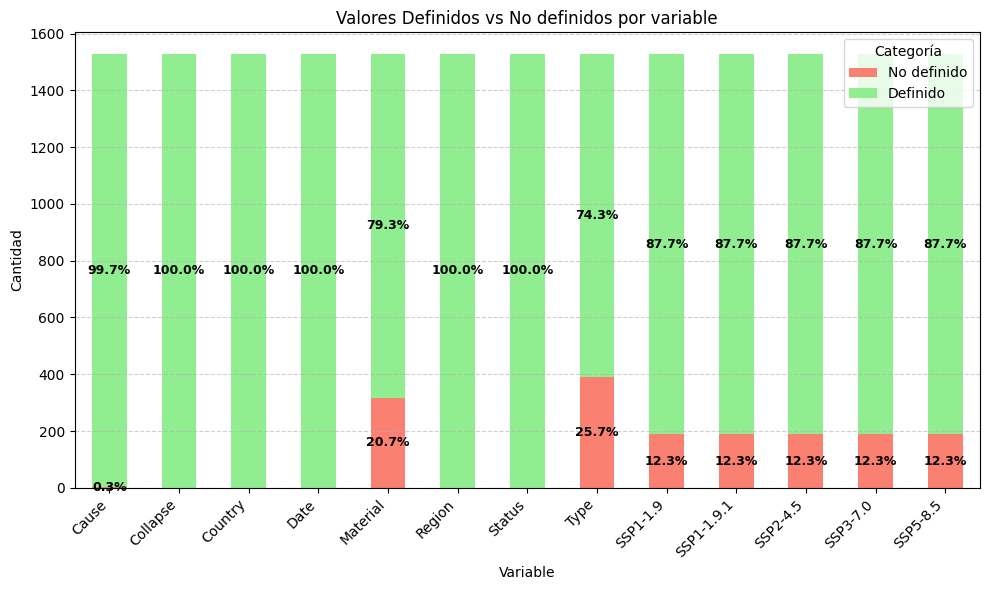

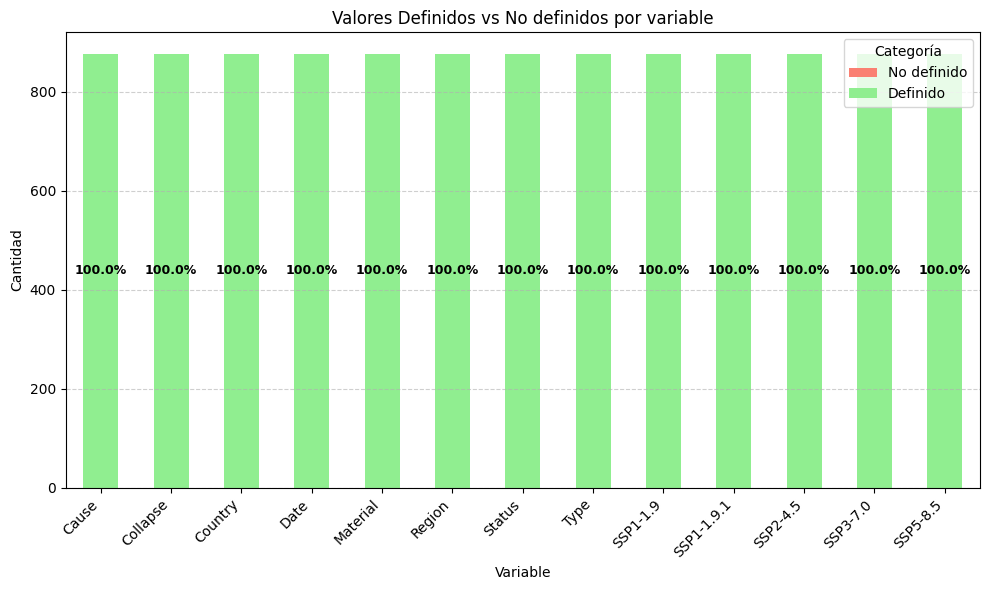

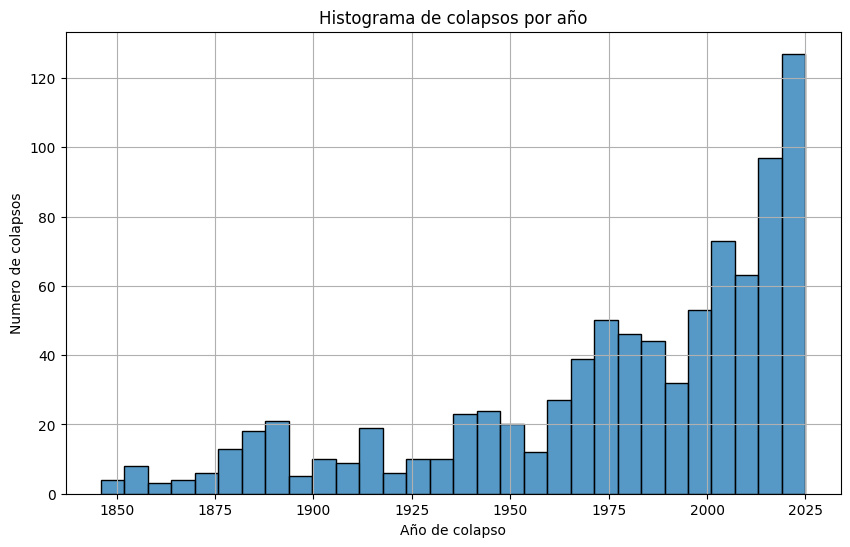

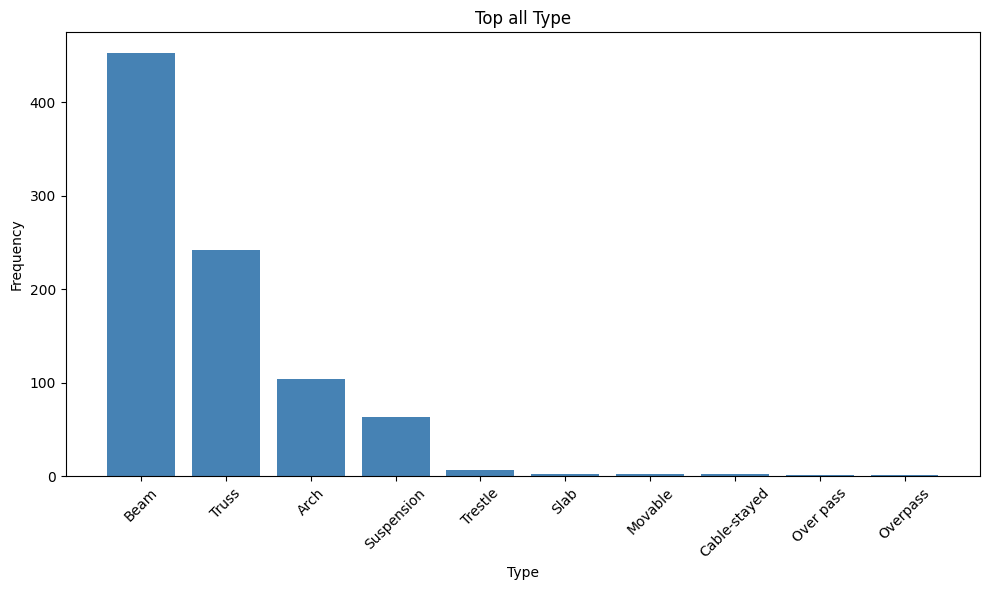

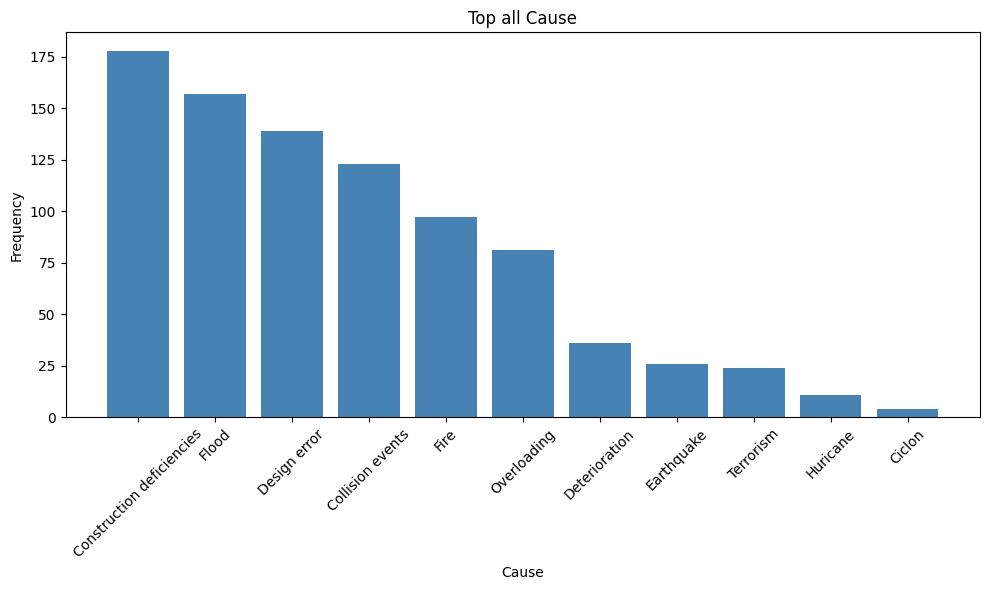

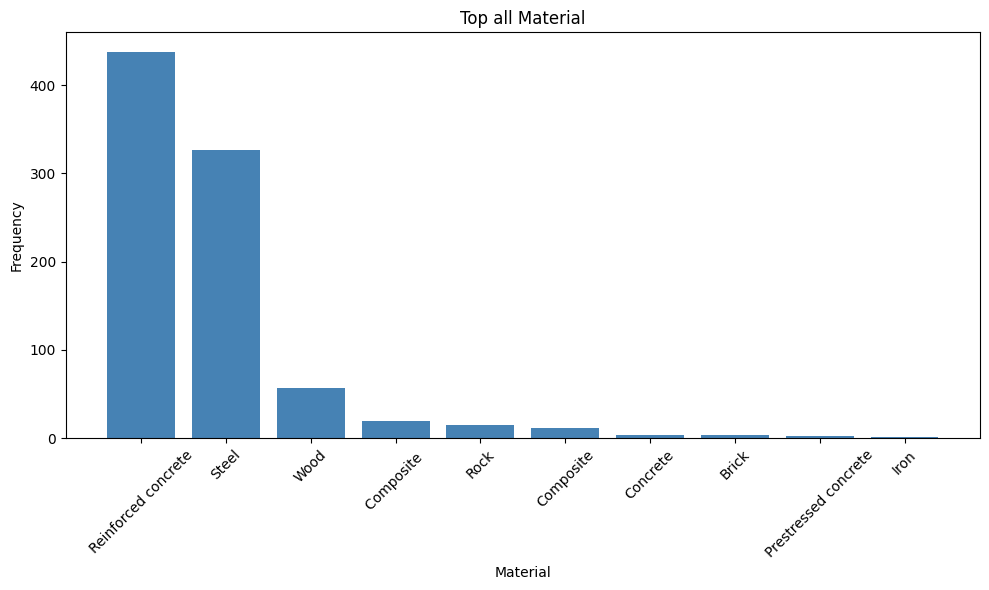

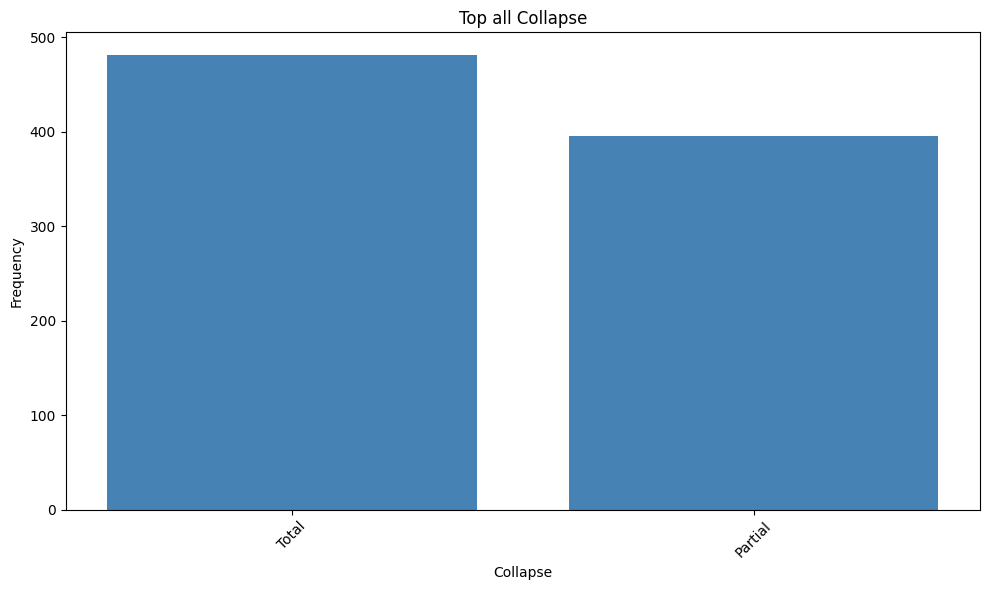

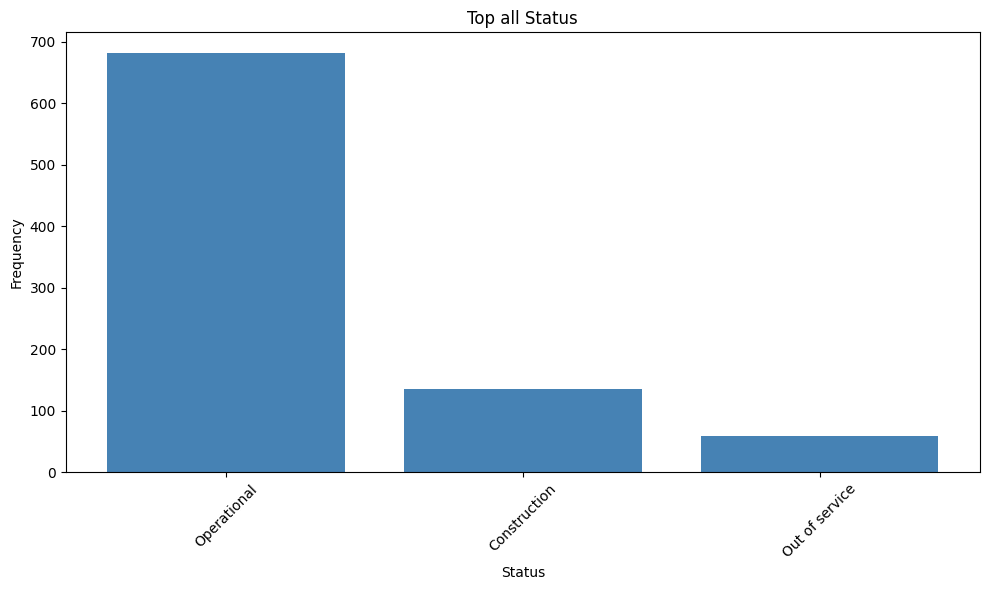

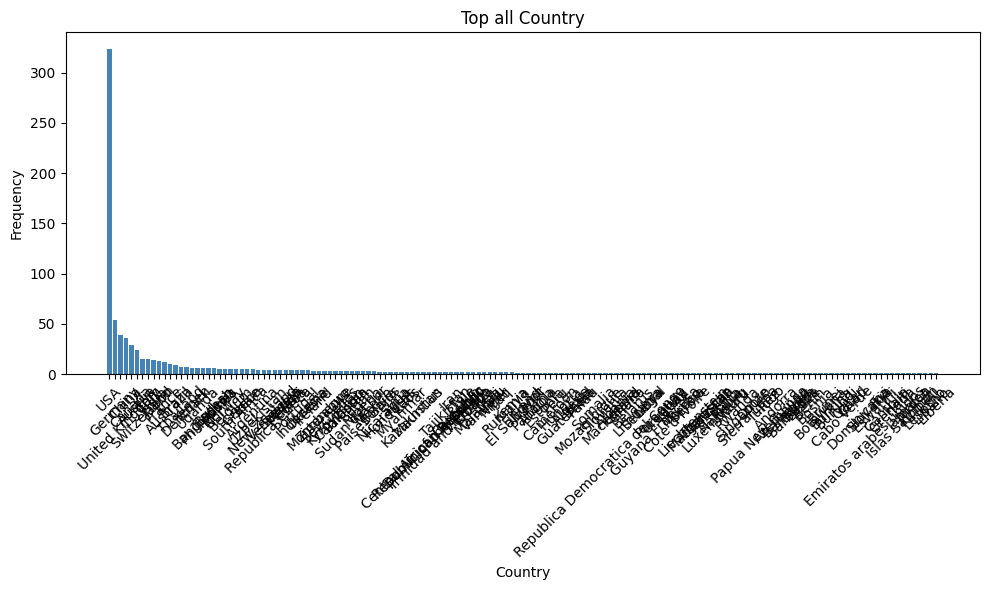

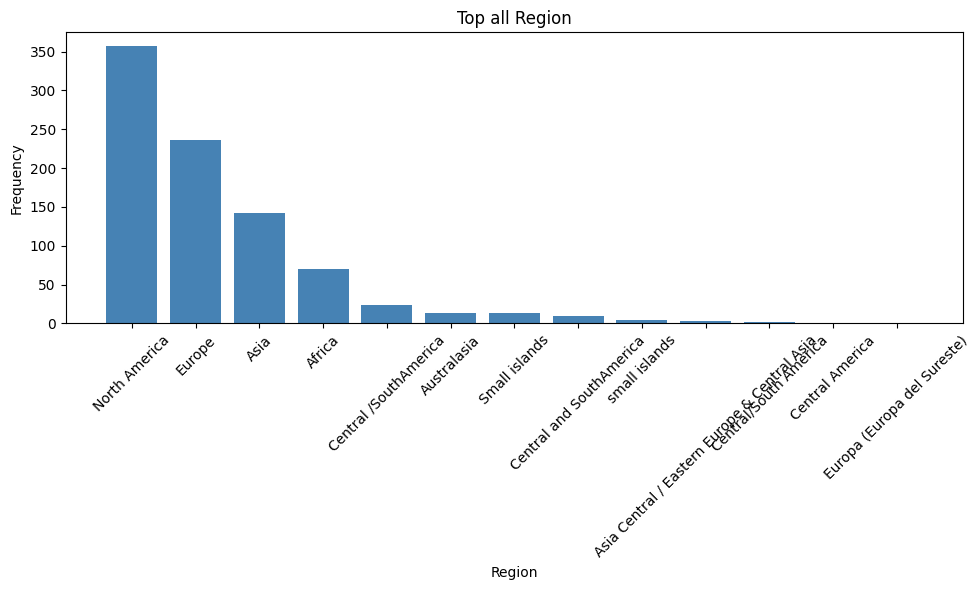

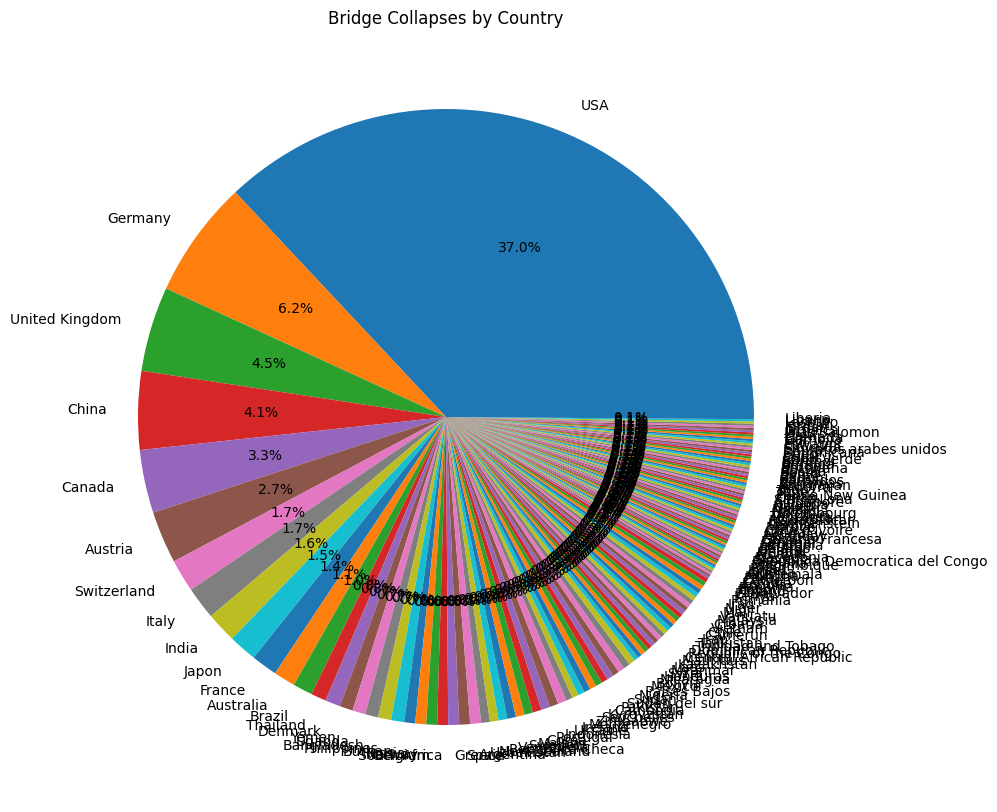

Count de X Type                 872
Cause                872
Material             872
Collapse             872
Status               872
Country              872
Region               872
Date                 872
temperature_1.9      872
temperature_1.9.1    872
temperature_4.5      872
temperature_7.0      872
temperature_8.5      872
dtype: int64


In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# %%
import pandas as pd

df2 = pd.read_csv(r'E:\Tesis\Data\raw3.csv', delimiter=';', engine='python')
df2


# %%
df2.rename(columns={
    "SSP1-1.9": "temperature_1.9",
    "SSP1-1.9.1": "temperature_1.9.1",  
    "SSP2-4.5": "temperature_4.5",
    "SSP3-7.0": "temperature_7.0",
    "SSP5-8.5": "temperature_8.5"
}, inplace=True)

# %%
df2.info()

# %%
def compare_not_defined_frequency(df, column_name):
    is_not_defined = df[column_name] == "Not defined"
    
    counts = {
        "Not defined": is_not_defined.sum(),
        "Defined": (~is_not_defined).sum()
    }

    count_series = pd.Series(counts)

    plt.figure(figsize=(6, 4))
    sns.barplot(x=count_series.index, y=count_series.values, palette="pastel")
    plt.title(f"'Not defined' vs Defined values in '{column_name}'")
    plt.ylabel("Count")
    plt.xlabel("Category")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# %%
import pandas as pd
import matplotlib.pyplot as plt

def stacked_not_defined_comparison(df, columns_to_check):
    # Etiquetas legibles para las temperaturas
    pretty_labels = {
        "temperature_1.9": "SSP1-1.9",
        "temperature_1.9.1": "SSP1-1.9.1",
        "temperature_4.5": "SSP2-4.5",
        "temperature_7.0": "SSP3-7.0",
        "temperature_8.5": "SSP5-8.5",
    }

    data = {
        "Variable": [],
        "Category": [],
        "Count": []
    }

    for col in columns_to_check:
        col_series = df[col]
        
        if pd.api.types.is_numeric_dtype(col_series):
            not_defined_count = col_series.isna().sum()
        else:
            col_series = col_series.astype(str).str.strip()
            not_defined_count = col_series.isin(["Not defined", "No definido", "#N/A", "ER"]).sum() + col_series.isna().sum()

        defined_count = df.shape[0] - not_defined_count

        data["Variable"].extend([col, col])
        data["Category"].extend(["No definido", "Definido"])
        data["Count"].extend([not_defined_count, defined_count])

    plot_df = pd.DataFrame(data)

    pivot_df = plot_df.pivot(index="Variable", columns="Category", values="Count").fillna(0)

    for cat in ["No definido", "Definido"]:
        if cat not in pivot_df.columns:
            pivot_df[cat] = 0
    pivot_df = pivot_df[["No definido", "Definido"]]

    # Cambiar nombres por etiquetas legibles
    pivot_df = pivot_df.rename(index=pretty_labels)

    # Graficar
    ax = pivot_df.plot(kind="bar", stacked=True, figsize=(10, 6), color=["salmon", "lightgreen"])
    plt.title("Valores Definidos vs No definidos por variable")
    plt.ylabel("Cantidad")
    plt.xlabel("Variable")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Categoría")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)

    for i, variable in enumerate(pivot_df.index):
        total = pivot_df.loc[variable].sum()
        y_offset = 0
        for category in pivot_df.columns:
            value = pivot_df.loc[variable, category]
            if value > 0:
                percent = (value / total) * 100
                ax.text(i, y_offset + value / 2, f"{percent:.1f}%", ha='center', va='center',
                        fontsize=9, color='black', fontweight='bold')
                y_offset += value

    plt.tight_layout()
    plt.show()


# %%
cat_cols=['Type','Cause','Material','Collapse','Status','Country','Region']

num_cols = [
    'Date',
    'temperature_1.9',
    'temperature_1.9.1',
    'temperature_4.5',
    'temperature_7.0',
    'temperature_8.5'
]



df2=df2.dropna()
df2=df2.drop(columns=['Name','Sub-region'])

target=['Cause']

features=cat_cols+num_cols
X=df2[features].copy()


stacked_not_defined_comparison(X, features)


# %%
X = X[
    (X['Type'] != "Not defined") &
    (X['Material'] != "Not defined") &
    (X['Cause'] != "No definido") &
    (X['Date'] != 'No date') &
    (X['Date'] != 'no date') &
    (X['temperature_1.9'] != "ER") &
    (X['temperature_1.9'] != "#N/A") &
    (X['temperature_1.9.1'] != "ER") &
    (X['temperature_1.9.1'] != "#N/A") &
    (X['temperature_4.5'] != "ER") &
    (X['temperature_4.5'] != "#N/A") &
    (X['temperature_7.0'] != "ER") &
    (X['temperature_7.0'] != "#N/A") &
    (X['temperature_8.5'] != "ER") &
    (X['temperature_8.5'] != "#N/A")
]


X['Date']=pd.to_datetime(X['Date'],errors='coerce').dt.year
X=X.dropna(subset=['Date'])




# %%
stacked_not_defined_comparison(X, features)

# %%
temperature_columns = [
    'temperature_1.9',
    'temperature_1.9.1',
    'temperature_4.5',
    'temperature_7.0',
    'temperature_8.5'
]

for col in temperature_columns:
    X[col] = (
        X[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .str.replace(r'[^\d\.\-]', '', regex=True)
        .str.strip()
    )

X[temperature_columns] = X[temperature_columns].apply(pd.to_numeric, errors='coerce')


# %% [markdown]
# # Frecuencias
# 

# %%
df=X

# %%
plt.figure(figsize=(10,6))
sns.histplot(df['Date'].dropna(), bins=30, kde=False)
plt.xlabel('Año de colapso')
plt.ylabel('Numero de colapsos')
plt.title('Histograma de colapsos por año')
plt.grid(True)
plt.show()


# %%
def plot_top_values(df, column, n=None):
    if n is None:
        values = df[column].value_counts()
    else:
        values = df[column].value_counts().head(n)
    
    plt.figure(figsize=(10, 6))
    plt.bar(values.index, values.values, color='steelblue')
    plt.title('Top ' + (str(n) if n else 'all') + ' ' + column)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# %%
temp_cat_cols=cat_cols.copy()
temp_cat_cols.append("Cause")

for column in cat_cols:
    plot_top_values(df,column)


# %%

country_counts = df['Country'].value_counts()
country_counts.plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')
plt.title('Bridge Collapses by Country')
plt.ylabel('')
plt.show()

# %% [markdown]
# # Eliminacion de Outliers

# %%

temp_df=X

## Eliminacion de Causes que tienen pocos valores

X = X[
    (X['Cause'] != "Ciclon") 
]
temp_df=X


print("Count de X "+str(X.count()))

Y=X['Cause'].copy()

cat_cols.remove("Cause")
X=X.drop(columns=['Cause'])


In [116]:
temp_df

,Type,Cause,Material,Collapse,Status,Country,Region,Date,temperature_1.9,temperature_1.9.1,temperature_4.5,temperature_7.0,temperature_8.5
0,Truss,Terrorism,Steel,Total,Operational,Germany,Europe,1945.0,-0.27856,-0.021440,-0.02468,0.082760,-0.024680
1,Trestle,Terrorism,Composite,Total,Operational,Canada,North America,2012.0,1.58241,1.726760,1.92925,1.756970,1.971835
2,Beam,Terrorism,Reinforced concrete,Total,Operational,Canada,North America,2024.0,2.58803,2.722245,3.03332,2.274200,2.578360
23,Suspension,Terrorism,Reinforced concrete,Total,Operational,El Salvador,Central /SouthAmerica,1984.0,0.21845,0.167995,0.11754,0.167995,0.114890
34,Suspension,Terrorism,Rock,Total,Operational,Russia,Europe,1905.0,-0.10731,-0.244030,-0.15941,-0.386810,-0.328650
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,Beam,Overloading,Reinforced concrete,Total,Operational,Jamaica,Small islands,2024.0,2.58803,1.154960,1.20863,1.043770,1.130410
1532,Beam,Construction deficiencies,Reinforced concrete,Total,Construction,Jordan,Asia,2003.0,1.06424,0.899050,1.01453,1.045700,1.014530
1534,Beam,Flood,Composite,Partial,Operational,Lesotho,Africa,2020.0,1.67965,1.289420,1.18791,1.369190,1.309620
1535,Beam,Terrorism,Reinforced concrete,Partial,Operational,Libano,Asia,2006.0,0.97806,1.246685,1.38773,1.246685,1.270530


# NO  STATUS REGION SUBREGION

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   N°                 1538 non-null   int64 
 1   Date               1538 non-null   object
 2   Name               1538 non-null   object
 3   Type               1538 non-null   object
 4   Cause              1538 non-null   object
 5   Material           1538 non-null   object
 6   Collapse           1538 non-null   object
 7   Status             1538 non-null   object
 8   Country            1538 non-null   object
 9   Region             1538 non-null   object
 10  Sub-region         1538 non-null   object
 11  temperature_1.9    1528 non-null   object
 12  temperature_1.9.1  1528 non-null   object
 13  temperature_4.5    1528 non-null   object
 14  temperature_7.0    1528 non-null   object
 15  temperature_8.5    1528 non-null   object
dtypes: int64(1), object(15)
memory usage: 192.

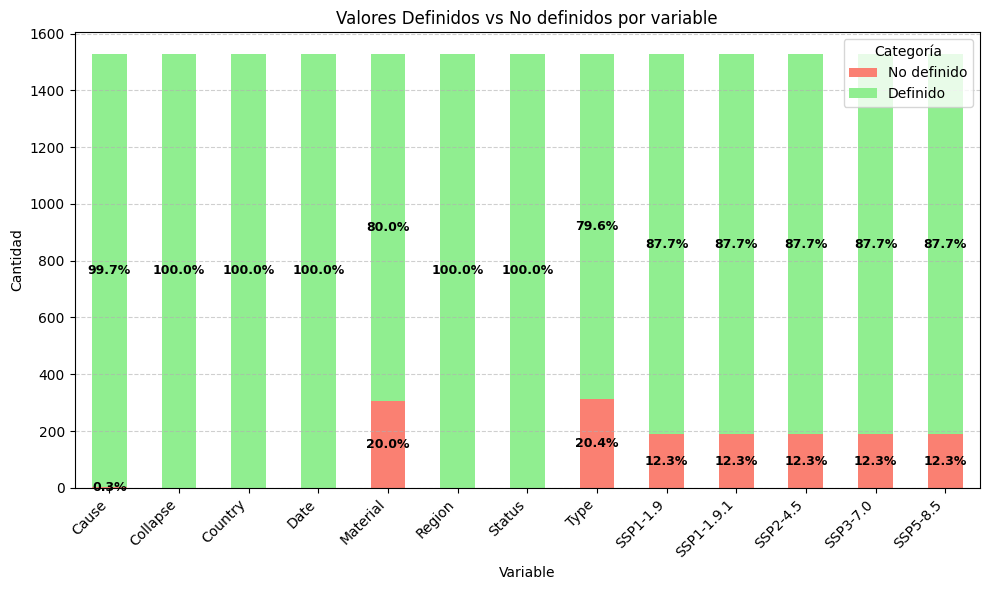

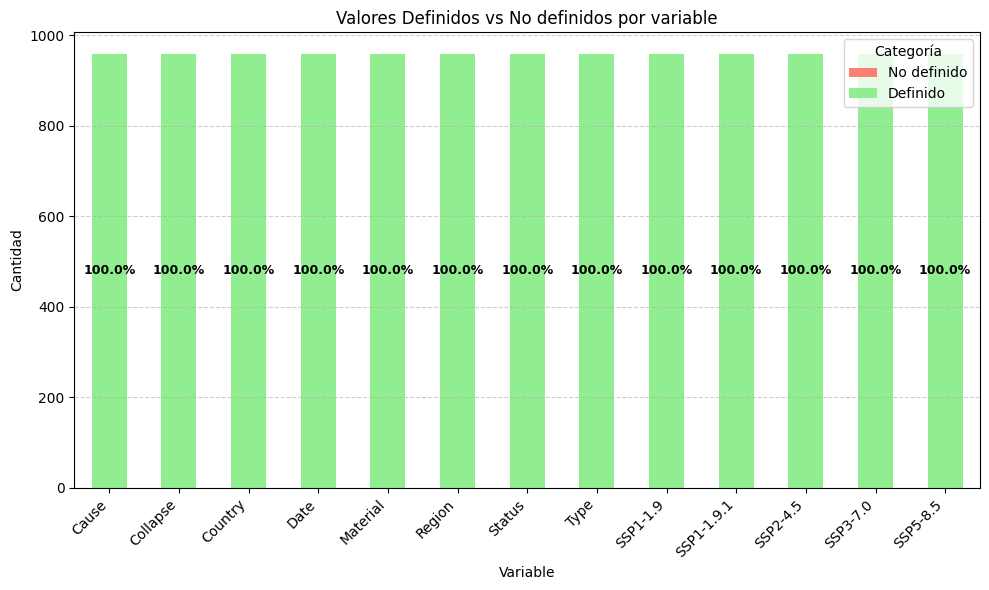

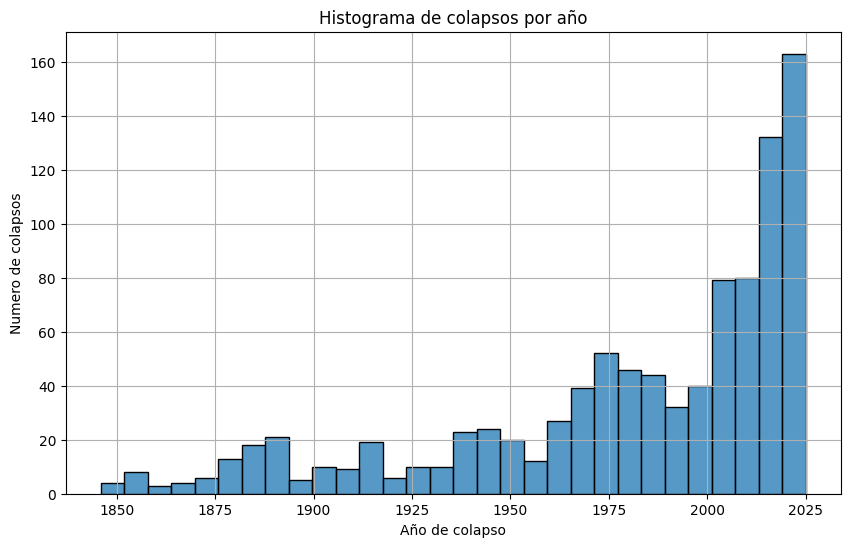

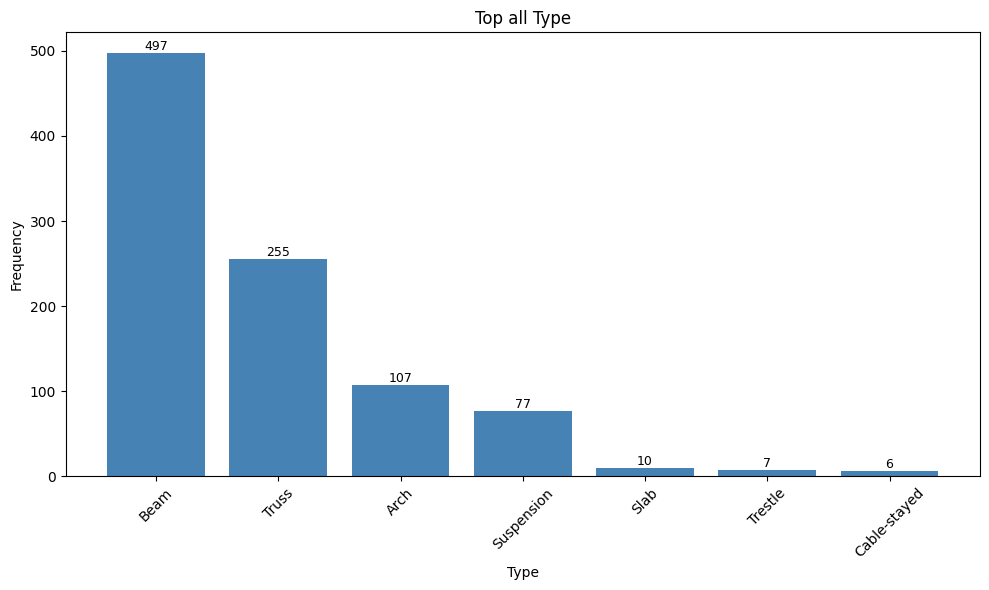

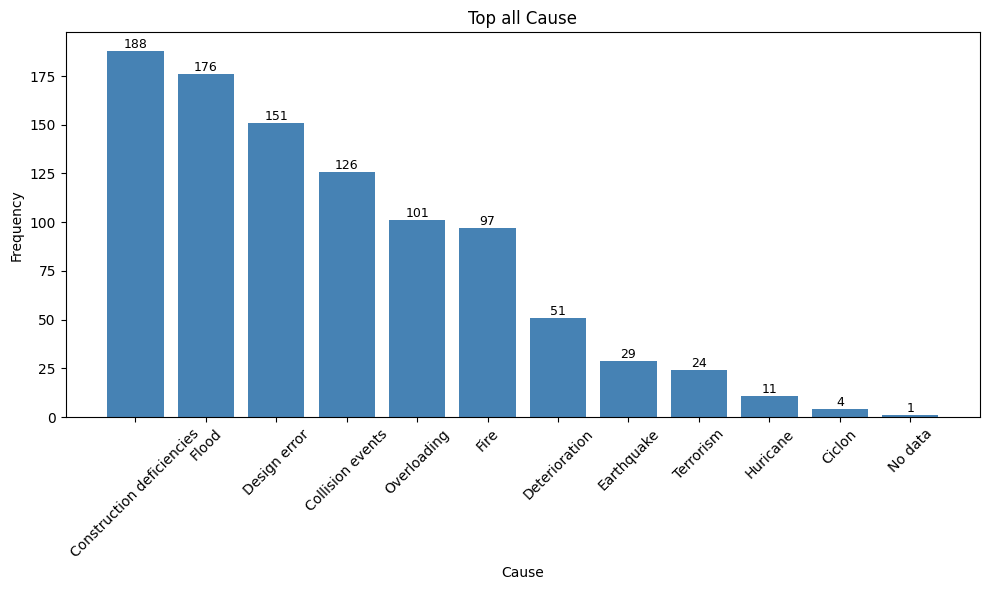

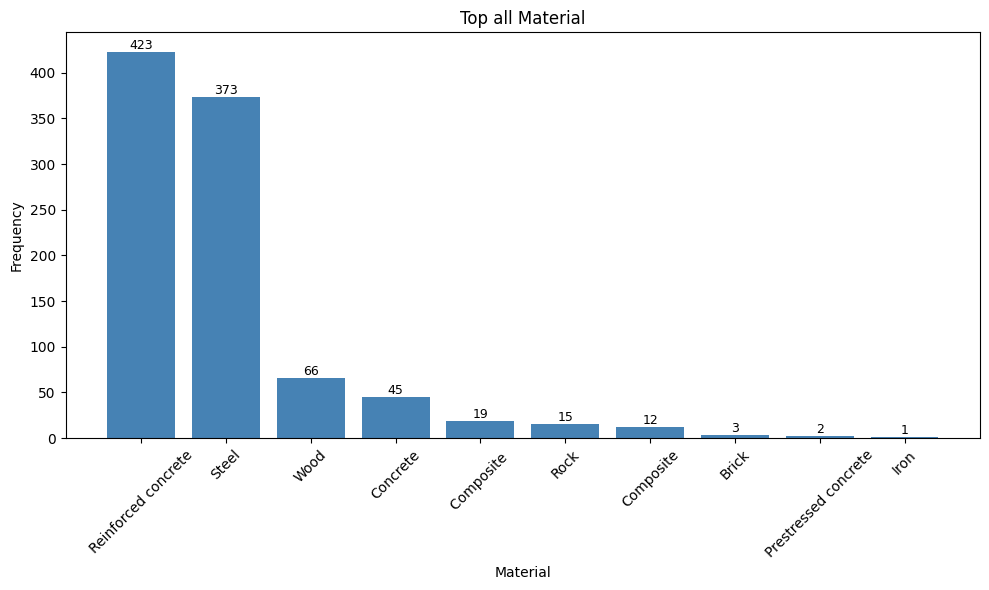

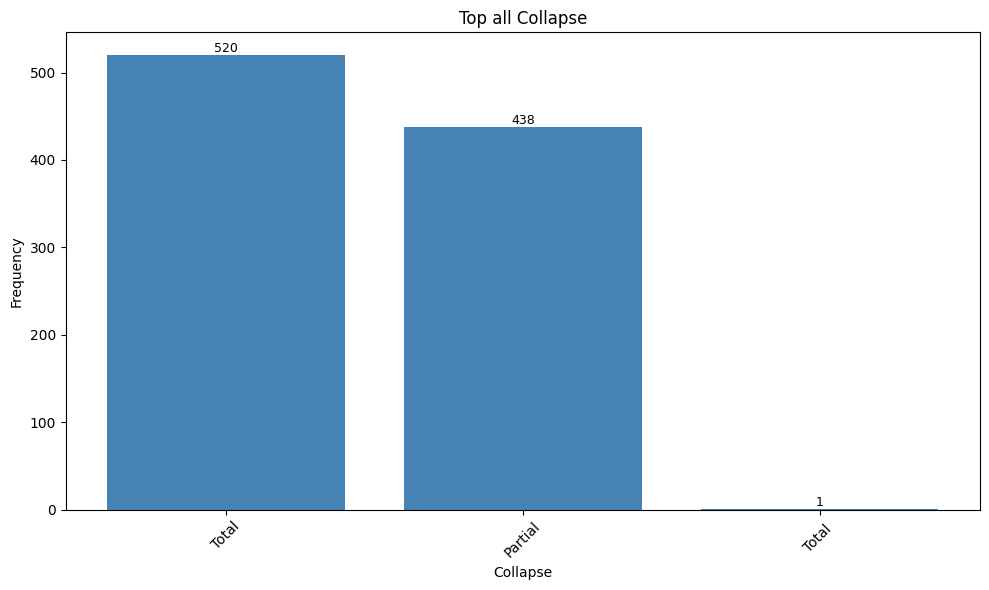

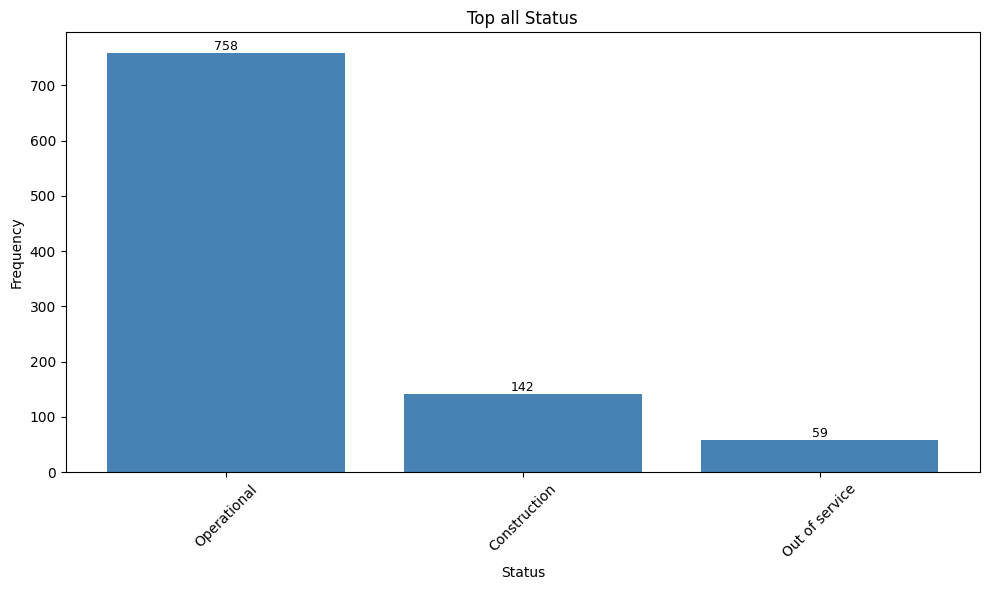

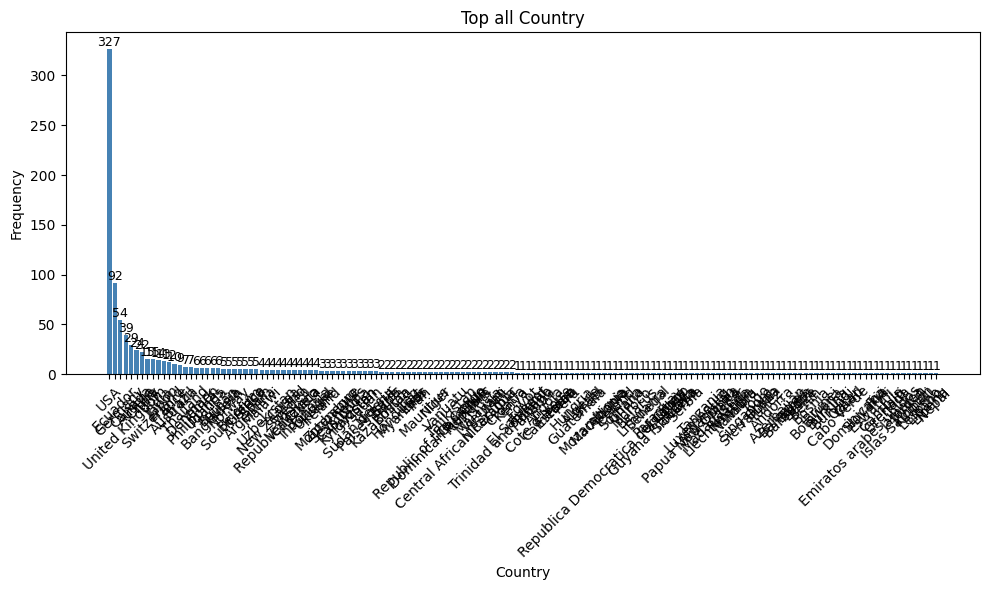

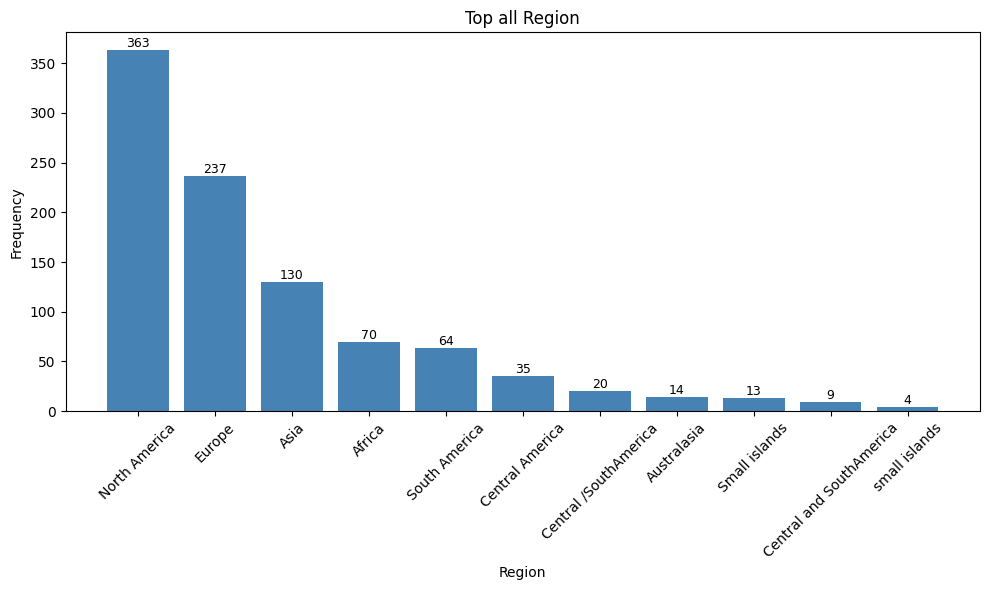

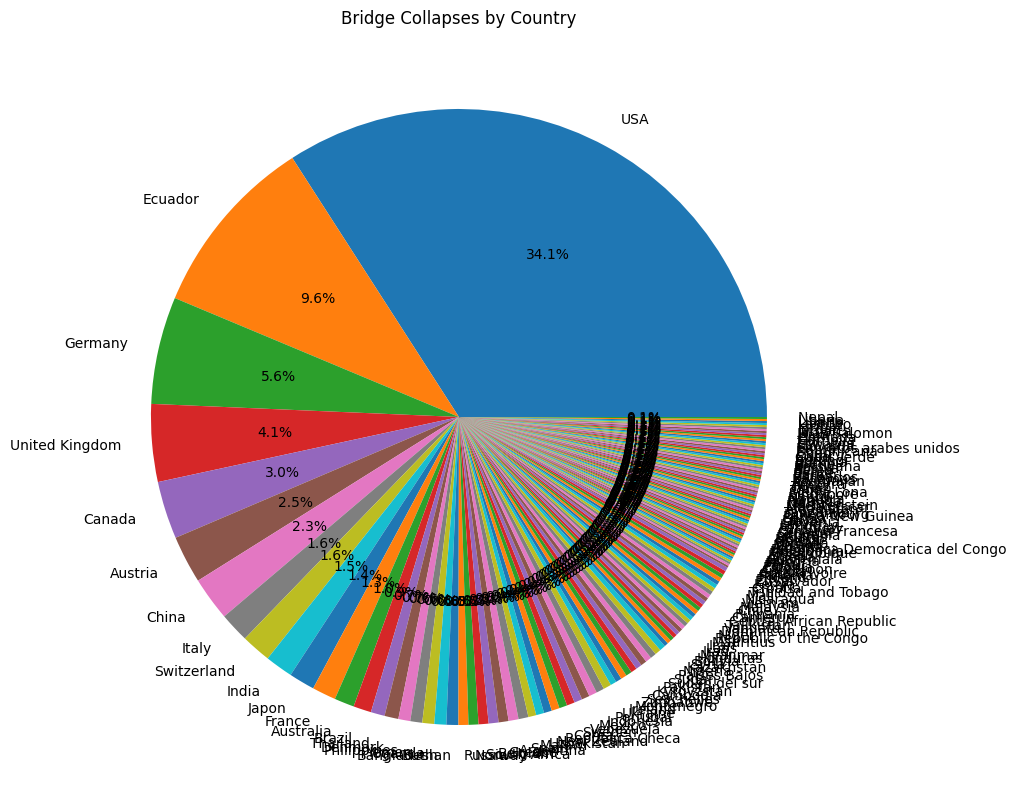

Count de X Type                 840
Cause                840
Material             840
Collapse             840
Status               840
Country              840
Region               840
Date                 840
temperature_1.9      840
temperature_1.9.1    840
temperature_4.5      840
temperature_7.0      824
temperature_8.5      840
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 840 entries, 41 to 1537
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Type               840 non-null    object 
 1   Cause              840 non-null    object 
 2   Material           840 non-null    object 
 3   Collapse           840 non-null    object 
 4   Status             840 non-null    object 
 5   Country            840 non-null    object 
 6   Region             840 non-null    object 
 7   Date               840 non-null    int32  
 8   temperature_1.9    840 non-null    float64
 9   temperature_1.9.

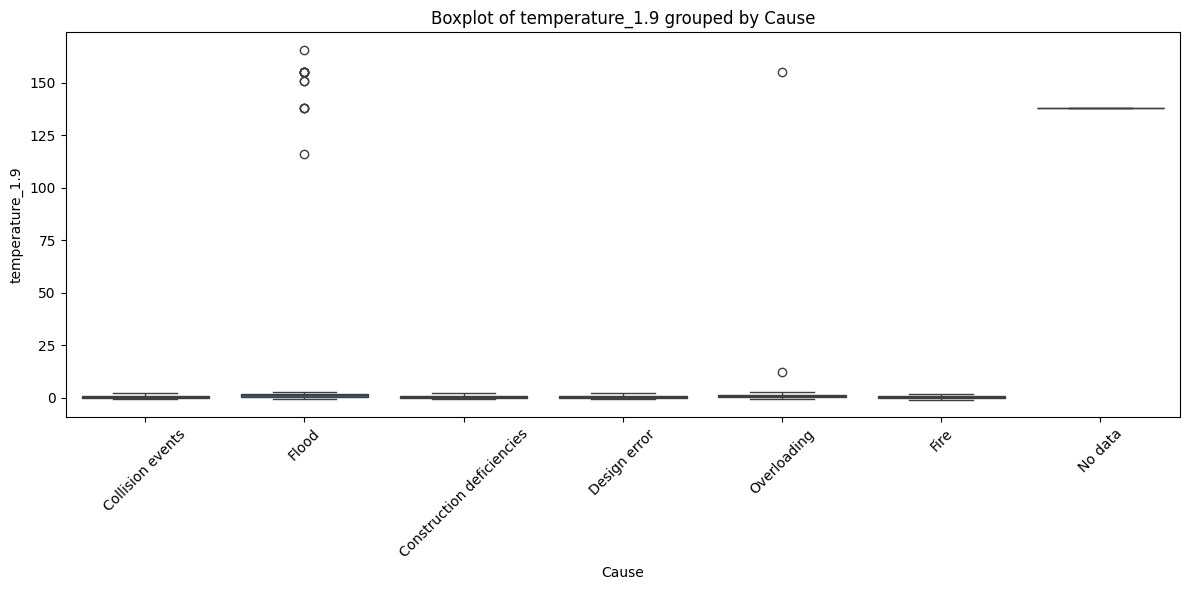

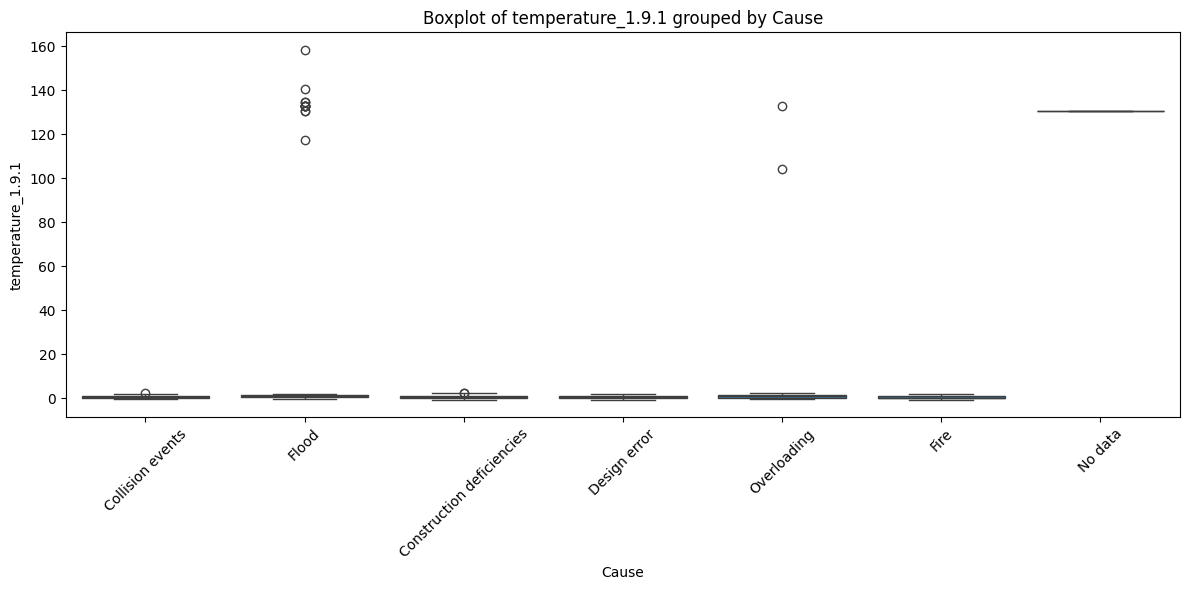

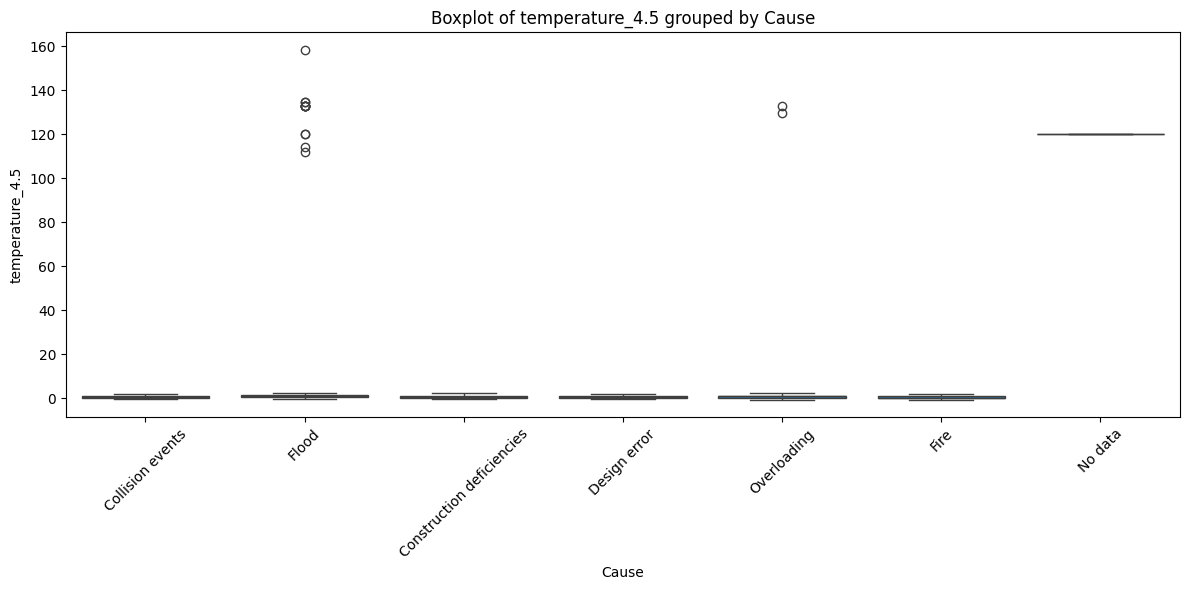

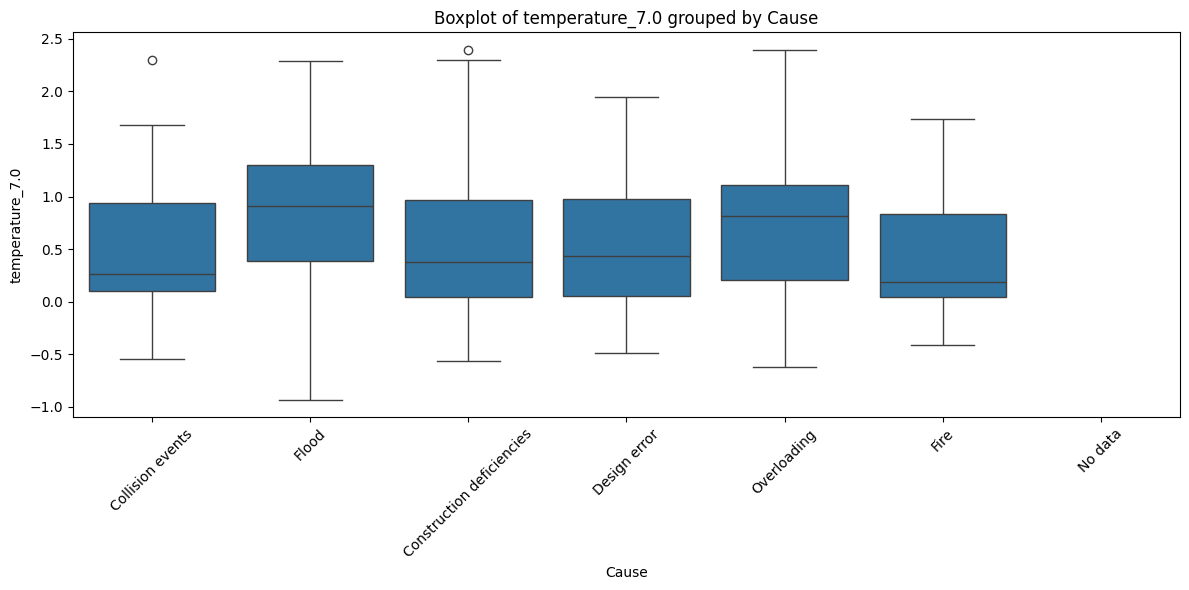

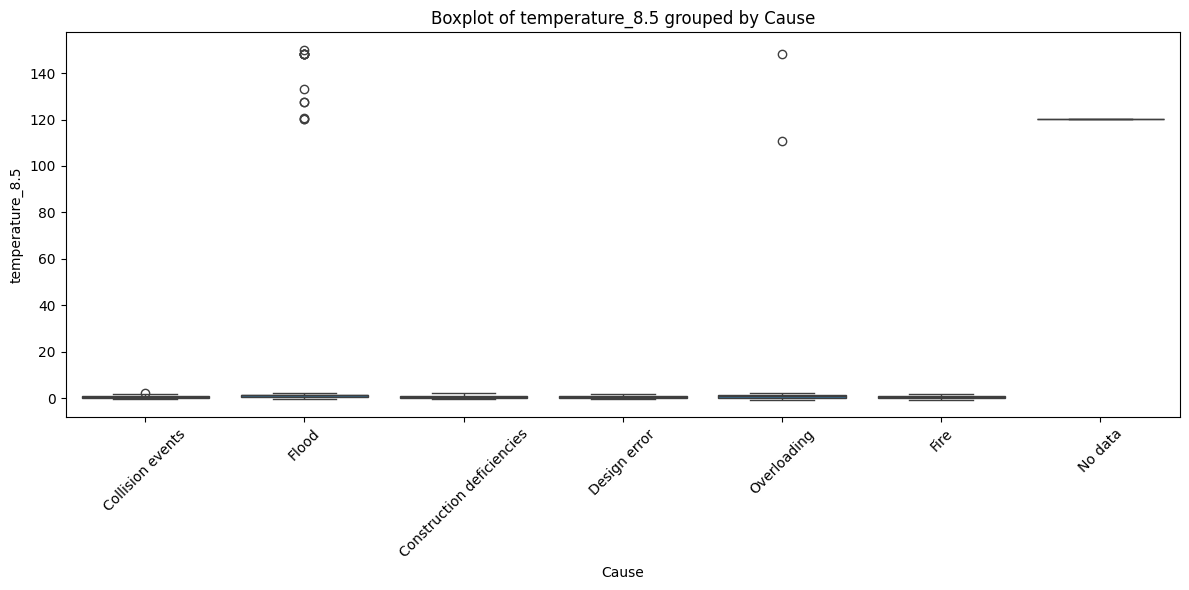

Removing 16 rows identified as outliers.


In [117]:
# %%
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# %%
import pandas as pd

#df2 = pd.read_csv(r'E:\Tesis\Data\raw3.csv', delimiter=';', engine='python')
df2 = pd.read_csv(r'E:\Tesis\Data\raw4.csv', encoding='latin-1')
df2


# %%
df2.rename(columns={
    "SSP1-1.9": "temperature_1.9",
    "SSP1-1.9.1": "temperature_1.9.1",  
    "SSP2-4.5": "temperature_4.5",
    "SSP3-7.0": "temperature_7.0",
    "SSP5-8.5": "temperature_8.5"
}, inplace=True)

# %%
df2.info()

# %%
def compare_not_defined_frequency(df, column_name):
    is_not_defined = df[column_name] == "Not defined"
    
    counts = {
        "Not defined": is_not_defined.sum(),
        "Defined": (~is_not_defined).sum()
    }

    count_series = pd.Series(counts)

    plt.figure(figsize=(6, 4))
    sns.barplot(x=count_series.index, y=count_series.values, palette="pastel")
    plt.title(f"'Not defined' vs Defined values in '{column_name}'")
    plt.ylabel("Count")
    plt.xlabel("Category")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# %%
import pandas as pd
import matplotlib.pyplot as plt

def stacked_not_defined_comparison(df, columns_to_check):
    # Etiquetas legibles para las temperaturas
    pretty_labels = {
        "temperature_1.9": "SSP1-1.9",
        "temperature_1.9.1": "SSP1-1.9.1",
        "temperature_4.5": "SSP2-4.5",
        "temperature_7.0": "SSP3-7.0",
        "temperature_8.5": "SSP5-8.5",
    }

    data = {
        "Variable": [],
        "Category": [],
        "Count": []
    }

    for col in columns_to_check:
        col_series = df[col]
        
        if pd.api.types.is_numeric_dtype(col_series):
            not_defined_count = col_series.isna().sum()
        else:
            col_series = col_series.astype(str).str.strip()
            not_defined_count = col_series.isin(["Not defined", "No definido", "#N/A", "ER"]).sum() + col_series.isna().sum()

        defined_count = df.shape[0] - not_defined_count

        data["Variable"].extend([col, col])
        data["Category"].extend(["No definido", "Definido"])
        data["Count"].extend([not_defined_count, defined_count])

    plot_df = pd.DataFrame(data)

    pivot_df = plot_df.pivot(index="Variable", columns="Category", values="Count").fillna(0)

    for cat in ["No definido", "Definido"]:
        if cat not in pivot_df.columns:
            pivot_df[cat] = 0
    pivot_df = pivot_df[["No definido", "Definido"]]

    # Cambiar nombres por etiquetas legibles
    pivot_df = pivot_df.rename(index=pretty_labels)

    # Graficar
    ax = pivot_df.plot(kind="bar", stacked=True, figsize=(10, 6), color=["salmon", "lightgreen"])
    plt.title("Valores Definidos vs No definidos por variable")
    plt.ylabel("Cantidad")
    plt.xlabel("Variable")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Categoría")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)

    for i, variable in enumerate(pivot_df.index):
        total = pivot_df.loc[variable].sum()
        y_offset = 0
        for category in pivot_df.columns:
            value = pivot_df.loc[variable, category]
            if value > 0:
                percent = (value / total) * 100
                ax.text(i, y_offset + value / 2, f"{percent:.1f}%", ha='center', va='center',
                        fontsize=9, color='black', fontweight='bold')
                y_offset += value

    plt.tight_layout()
    plt.show()


# %%
cat_cols=['Type','Cause','Material','Collapse','Status','Country','Region']

num_cols = [
    'Date',
    'temperature_1.9',
    'temperature_1.9.1',
    'temperature_4.5',
    'temperature_7.0',
    'temperature_8.5'
]



df2=df2.dropna()
df2=df2.drop(columns=['Name','Sub-region'])

target=['Cause']

features=cat_cols+num_cols
X=df2[features].copy()


stacked_not_defined_comparison(X, features)


# %%
X = X[
    (X['Type'] != "Not defined") &
    (X['Material'] != "Not defined") &
    (X['Cause'] != "No definido") &
    (X['Date'] != 'No date') &
    (X['Date'] != 'no date') &
    (X['temperature_1.9'] != "ER") &
    (X['temperature_1.9'] != "#N/A") &
    (X['temperature_1.9.1'] != "ER") &
    (X['temperature_1.9.1'] != "#N/A") &
    (X['temperature_4.5'] != "ER") &
    (X['temperature_4.5'] != "#N/A") &
    (X['temperature_7.0'] != "ER") &
    (X['temperature_7.0'] != "#N/A") &
    (X['temperature_8.5'] != "ER") &
    (X['temperature_8.5'] != "#N/A")
]


X['Date']=pd.to_datetime(X['Date'],errors='coerce').dt.year
X=X.dropna(subset=['Date'])




# %%
stacked_not_defined_comparison(X, features)

# %%
len(X)

# %%
temperature_columns = [
    'temperature_1.9',
    'temperature_1.9.1',
    'temperature_4.5',
    'temperature_7.0',
    'temperature_8.5'
]

for col in temperature_columns:
    X[col] = (
        X[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .str.replace(r'[^\d\.\-]', '', regex=True)
        .str.strip()
    )

X[temperature_columns] = X[temperature_columns].apply(pd.to_numeric, errors='coerce')


# %% [markdown]
# # Frecuencias
# 

# %%
df=X

# %%
plt.figure(figsize=(10,6))
sns.histplot(df['Date'].dropna(), bins=30, kde=False)
plt.xlabel('Año de colapso')
plt.ylabel('Numero de colapsos')
plt.title('Histograma de colapsos por año')
plt.grid(True)
plt.show()


# %%
import matplotlib.pyplot as plt

def plot_top_values(df, column, n=None):
    if n is None:
        values = df[column].value_counts()
    else:
        values = df[column].value_counts().head(n)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(values.index, values.values, color='steelblue')
    
    # Add labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # x position (center of bar)
            height,                             # y position (top of bar)
            str(height),                        # text
            ha='center', va='bottom', fontsize=9
        )
    
    plt.title('Top ' + (str(n) if n else 'all') + ' ' + column)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# %%
temp_cat_cols=cat_cols.copy()
temp_cat_cols.append("Cause")

for column in cat_cols:
    plot_top_values(df,column)


# %%

country_counts = df['Country'].value_counts()
country_counts.plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')
plt.title('Bridge Collapses by Country')
plt.ylabel('')
plt.show()

# %% [markdown]
# # Eliminacion de Outliers

# %%

temp_df=X

## Eliminacion de Causes que tienen pocos valores

X = X[~X['Cause'].isin(["Ciclon", "Huricane", "Terrorism", "Deterioration",'Earthquake'])]



Y=X['Cause'].copy()

cat_cols.remove("Country")
cat_cols.remove("Region")
cat_cols.remove("Status")

temp_df=X


# %%
print("Count de X "+str(X.count()))

# %%
X.info()

# %%
temp_df

# %%
temp_df.info()

# %%
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplots_for_floats(df):
    float_cols = df.select_dtypes(include='float').columns

    for col in float_cols:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x='Cause', y=col)
        plt.xticks(rotation=45)
        plt.title(f'Boxplot of {col} grouped by Cause')
        plt.tight_layout()
        plt.show()


# %%
plot_boxplots_for_floats(temp_df)


# %%
def get_outlier_indices(df, cols):
    outlier_indices = set()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Get indices of outliers in this column
        outliers_col = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices.update(outliers_col)
    return outlier_indices

def remove_outliers(df):
    float_cols = df.select_dtypes(include='float').columns
    outlier_indices = get_outlier_indices(df, float_cols)
    print(f"Removing {len(outlier_indices)} rows identified as outliers.")
    return df.drop(index=outlier_indices)

temp_df = remove_outliers(temp_df)

root_df=temp_df

temp_df=temp_df.drop(columns=['Country','Region','Status','Date'])



# AutoEncoder

In [118]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [119]:
cat_cols

['Type', 'Cause', 'Material', 'Collapse']

In [120]:

# %%
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# %%
from sklearn.preprocessing import OrdinalEncoder


encoder = OrdinalEncoder()

X_encoded = encoder.fit_transform(temp_df[cat_cols])


# %%
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(cat_cols), index=temp_df.index)
X_encoded_df


X_encoded_df = pd.concat(
    [temp_df.drop(columns=cat_cols), X_encoded_df],
    axis=1
)
#



In [121]:
X_train, X_val = train_test_split(X_encoded_df, test_size=0.2, random_state=42)


### BEST MODEL MSE LOSS

In [122]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import pandas as pd

Latent dim = 3, Validation Loss final = 0.492991
Latent dim = 4, Validation Loss final = 0.094775
Latent dim = 5, Validation Loss final = 0.260363
Latent dim = 6, Validation Loss final = 0.249943
Latent dim = 7, Validation Loss final = 0.265251
Latent dim = 8, Validation Loss final = 0.103865


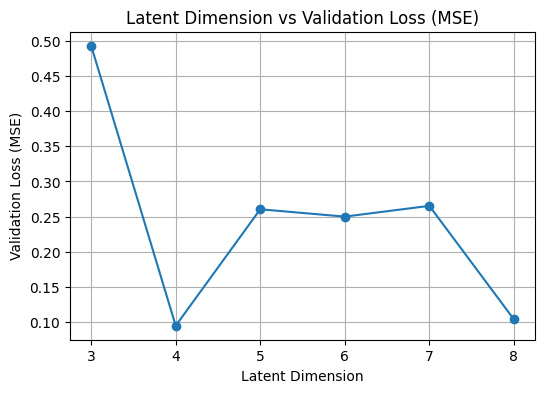

In [123]:
import matplotlib.pyplot as plt

latent_dims = [3, 4, 5, 6, 7, 8]
val_losses_final = []  # Lista para guardar val_loss de cada latent_dim
input_dim=3
input_dim=X_train.shape[1]

best_val_loss = float('inf')
best_model = None
best_latent_dim = None
best_history = None

for dim in latent_dims:
    # Definir arquitectura
    input_layer = layers.Input(shape=(input_dim,))
    x = layers.Dense(8, activation='relu')(input_layer)
    latent = layers.Dense(dim, activation='relu',
                          activity_regularizer=regularizers.l1(1e-4))(x)
    x = layers.Dense(8, activation='relu')(latent)
    output_layer = layers.Dense(input_dim, activation='linear')(x)

    autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Entrenar
    history = autoencoder.fit(
        X_train, X_train,
        validation_data=(X_val, X_val),
        epochs=100,
        batch_size=32,
        shuffle=True,
        verbose=0
    )

    # Guardar el val_loss final
    val_loss_final = history.history['val_loss'][-1]
    val_losses_final.append(val_loss_final)

    print(f"Latent dim = {dim}, Validation Loss final = {val_loss_final:.6f}")

    # Guardar el mejor modelo
    if val_loss_final < best_val_loss:
        best_val_loss = val_loss_final
        best_latent_dim = dim
        best_model = autoencoder
        best_history = history

# Graficar latent_dim vs val_loss
plt.figure(figsize=(6,4))
plt.plot(latent_dims, val_losses_final, marker='o')
plt.title("Latent Dimension vs Validation Loss (MSE)")
plt.xlabel("Latent Dimension")
plt.ylabel("Validation Loss (MSE)")
plt.grid(True)
plt.show()


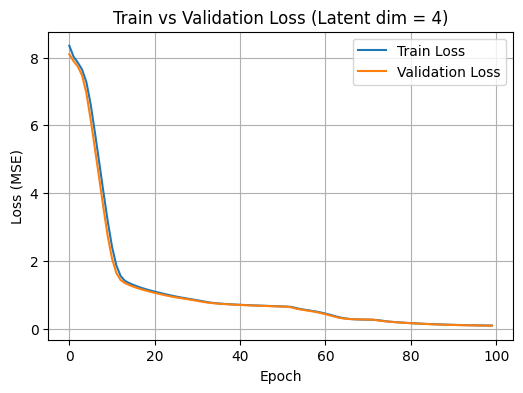

In [124]:
plt.figure(figsize=(6,4))
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title(f"Train vs Validation Loss (Latent dim = {best_latent_dim})")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

In [125]:
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], alpha=0.5)
# ax.set_title("Espacio Latente 3D")
# ax.set_xlabel("Z1")
# ax.set_ylabel("Z2")
# ax.set_zlabel("Z3")
# plt.tight_layout()
# plt.show()


In [126]:
from tensorflow.keras import layers, models, regularizers

# Crear encoder usando la misma arquitectura
input_layer = layers.Input(shape=(input_dim,))
x = layers.Dense(8, activation='relu')(input_layer)
latent = layers.Dense(best_latent_dim, activation='relu',
                      activity_regularizer=regularizers.l1(1e-4))(x)

encoder = models.Model(inputs=input_layer, outputs=latent)

# Obtener la representación latente de todo el dataset
Z = encoder.predict(X_encoded_df)
print("Z shape:", Z.shape)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Z shape: (824, 4)


In [127]:
# from imblearn.over_sampling import SMOTE

# print("Antes SMOTE:", Y.value_counts())

# smote = SMOTE(random_state=42)
# Z, Y = smote.fit_resample(Z, Y)

# print("Despues SMOTE:", Y.value_counts())


# TSNE

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


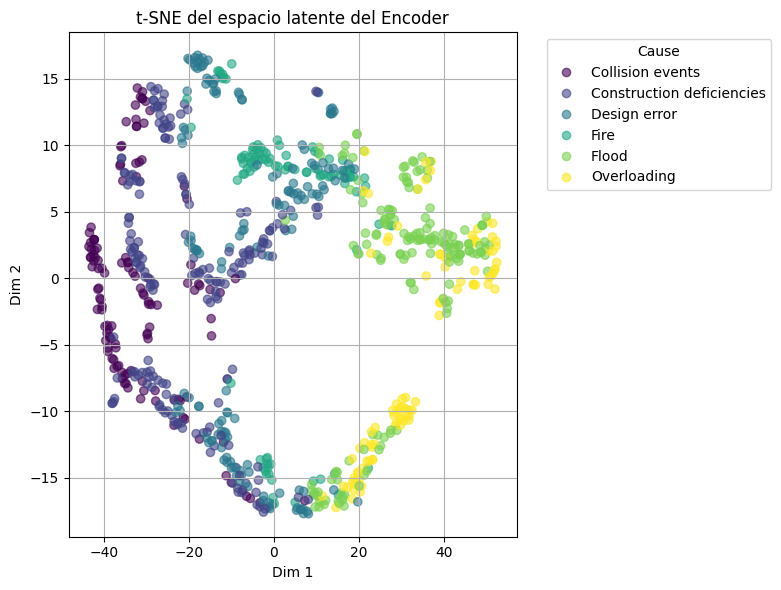

In [128]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Z es la salida del encoder
Z = encoder.predict(X_encoded_df)

# t-SNE del espacio latente
Z_tsne = TSNE(n_components=2, random_state=42).fit_transform(Z)

# Etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(temp_df['Cause'])

# Graficar
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Z_tsne[:, 0], Z_tsne[:, 1], c=y_encoded, cmap='viridis', alpha=0.6)

# Crear leyenda personalizada
handles, _ = scatter.legend_elements()
labels = le.inverse_transform(range(len(handles)))

# Colocar la leyenda fuera del gráfico
plt.legend(handles, labels, title="Cause", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("t-SNE del espacio latente del Encoder")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.tight_layout()  # Ajusta para evitar que se recorte la leyenda
plt.show()


In [129]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
# from sklearn.manifold import TSNE
# import matplotlib.patches as mpatches

# ordinal_encoder = OrdinalEncoder()
# X_encoded = ordinal_encoder.fit_transform(X)

# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(Y)

# scaler = StandardScaler()

# num_vars = X.shape[1]
# cols = 5
# rows = (num_vars // cols) + 1

# fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*3))
# axs = axs.flatten()

# class_names = label_encoder.classes_

# for i, col in enumerate(X.columns):
#     feature_scaled = scaler.fit_transform(X_encoded[:, [i]]).ravel()
#     mini_df = np.column_stack((feature_scaled, y_encoded))
#     tsne = TSNE(n_components=2, random_state=42, n_iter=300)
#     tsne_result = tsne.fit_transform(mini_df)
    
#     scatter = axs[i].scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_encoded, cmap='tab10', alpha=0.7)
#     axs[i].set_title(f't-SNE: {col} vs Target')
#     axs[i].set_xticks([])
#     axs[i].set_yticks([])

# for j in range(i+1, len(axs)):
#     fig.delaxes(axs[j])

# # Crear leyenda global
# handles = []
# for class_idx, class_name in enumerate(class_names):
#     handles.append(mpatches.Patch(color=scatter.cmap(scatter.norm(class_idx)), label=class_name))

# fig.legend(handles=handles, loc='upper center', ncol=len(class_names), fontsize=8)
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta el espacio para la leyenda arriba

# plt.show()


In [216]:
#Saving Z 

np.save("Z_latent.npy", Z)

In [130]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [131]:
#encodificacion

preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    #('scale', StandardScaler(), num_cols)
])

X_processed = preprocessor.fit_transform(X)

X_processed= X_processed.toarray()

In [132]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score


def optimize_clustering(X, cluster_range=[2, 3, 4, 5]):
    results = []
    all_labels = []

    for k in cluster_range:
        models = [
            ("KMeans", KMeans(n_clusters=k, random_state=42)),
            ("Agglomerative", AgglomerativeClustering(n_clusters=k)),
            ("Spectral", SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')),
            ("GaussianMixture", GaussianMixture(n_components=k, random_state=42))
        ]

        for name, model in models:
            try:
                if name == "GaussianMixture":
                    model.fit(X)
                    labels = model.predict(X)
                    inertia = None
                elif name == "KMeans":
                    model.fit(X)
                    labels = model.labels_
                    inertia = model.inertia_
                else:
                    labels = model.fit_predict(X)
                    inertia = None

                # Save metrics
                silhouette = silhouette_score(X, labels)
                db_score = davies_bouldin_score(X, labels)
                ch_score = calinski_harabasz_score(X, labels)

                results.append({
                    "Model": name,
                    "Clusters": k,
                    "Silhouette": silhouette,
                    "Davies-Bouldin": db_score,
                    "Calinski-Harabasz": ch_score,
                    "Inertia": inertia,
                    "Labels" :labels
                })

                

            except Exception as e:
                print(f"Error with {name} k={k}: {e}")

    results_df = pd.DataFrame(results)

    return results_df


In [133]:
results_df= optimize_clustering(Z,range(2,7))
results_df

,Model,Clusters,Silhouette,Davies-Bouldin,Calinski-Harabasz,Inertia,Labels
0,KMeans,2,0.568279,0.610730,1793.113647,1087.606567,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Agglomerative,2,0.546219,0.566240,1392.505615,NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Spectral,2,0.564270,0.619351,1780.975952,NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,GaussianMixture,2,0.105548,1.640374,145.001556,NaN,"[1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, ..."
4,KMeans,3,0.464291,0.707006,1806.914917,640.555359,"[2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
5,Agglomerative,3,0.452032,0.720100,1694.753540,NaN,"[2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
6,Spectral,3,0.459780,0.686477,1723.815796,NaN,"[2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
7,GaussianMixture,3,0.089017,2.249047,303.035431,NaN,"[2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
8,KMeans,4,0.441709,0.747517,1919.677368,431.263184,"[2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
9,Agglomerative,4,0.376564,0.820449,1524.900757,NaN,"[2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."


# GRID SEARCH TESTING

In [185]:
def optimize_clustering(X, cluster_range=[2,3,4,5], y_true=None):
    param_grid = {
        "KMeans": {"n_init": [10, 20, 30, 40], "max_iter": [300, 600]},
        "Agglomerative": {"linkage": ["ward", "average", "complete"], "metric": ["euclidean"]},
        "Spectral": {"affinity": ["nearest_neighbors", "rbf"], "assign_labels": ["kmeans", "discretize"]},
        "GaussianMixture": {"covariance_type": ["full", "tied", "diag", "spherical"]}
    }

    results = []

    for k in cluster_range:
        for model_name in ["KMeans", "Agglomerative", "Spectral", "GaussianMixture"]:
            grid = param_grid[model_name]
            for params in (dict(zip(grid.keys(), values)) for values in product(*grid.values())):
                try:
                    # -----------------------------
                    # Build model
                    # -----------------------------
                    if model_name == "KMeans":
                        model = KMeans(n_clusters=k, random_state=42, **params)
                    elif model_name == "Agglomerative":
                        linkage = params["linkage"]
                        if linkage == "ward":
                            model = AgglomerativeClustering(n_clusters=k, linkage="ward")
                        else:
                            model = AgglomerativeClustering(n_clusters=k, linkage=linkage, metric=params["metric"])
                    elif model_name == "Spectral":
                        model = SpectralClustering(n_clusters=k, random_state=42, **params)
                    elif model_name == "GaussianMixture":
                        model = GaussianMixture(n_components=k, random_state=42, **params)

                    # -----------------------------
                    # Fit / Predict
                    # -----------------------------
                    if model_name == "GaussianMixture":
                        model.fit(X)
                        labels = model.predict(X)
                        inertia = None
                    elif model_name == "KMeans":
                        model.fit(X)
                        labels = model.labels_
                        inertia = model.inertia_
                    else:
                        labels = model.fit_predict(X)
                        inertia = None

                    # -----------------------------
                    # Compute Metrics
                    # -----------------------------
                    try:
                        sil = silhouette_score(X, labels)
                    except:
                        sil = np.nan
                    try:
                        db = davies_bouldin_score(X, labels)
                    except:
                        db = np.nan
                    try:
                        ch = calinski_harabasz_score(X, labels)
                    except:
                        ch = np.nan

                    if y_true is not None:
                        ari = adjusted_rand_score(y_true, labels)
                        nmi = normalized_mutual_info_score(y_true, labels)
                    else:
                        ari = np.nan
                        nmi = np.nan

                    combined = sil + (ch / 1000) - db

                    # -----------------------------
                    # Store results and keep model in memory
                    # -----------------------------
                    row = {
                        "Model": model_name,
                        "Clusters": k,
                        "Params": params,
                        "Labels": labels,
                        "Inertia": inertia,
                        "Silhouette": sil,
                        "DB": db,
                        "CH": ch,
                        "CombinedScore": combined,
                        "TrainedModel": model  # store model in memory
                    }

                    results.append(row)

                except Exception as e:
                    print(f"⚠ Error: {model_name}, k={k}, params={params}: {e}")

    return pd.DataFrame(results)


In [186]:
df_raw=optimize_clustering(Z, cluster_range=[2, 3, 4, 5,6])
df_raw=df_raw.drop('CombinedScore',axis=1)
df_raw

,Model,Clusters,Params,Labels,Inertia,Silhouette,DB,CH,TrainedModel
0,KMeans,2,"{'n_init': 10, 'max_iter': 300}","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1087.606567,0.568279,0.610730,1793.113647,"KMeans(n_clusters=2, n_init=10, random_state=42)"
1,KMeans,2,"{'n_init': 10, 'max_iter': 600}","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1087.606689,0.568279,0.610730,1793.113647,"KMeans(max_iter=600, n_clusters=2, n_init=10, ..."
2,KMeans,2,"{'n_init': 20, 'max_iter': 300}","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1087.606689,0.568279,0.610730,1793.113647,"KMeans(n_clusters=2, n_init=20, random_state=42)"
3,KMeans,2,"{'n_init': 20, 'max_iter': 600}","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1087.606567,0.568279,0.610730,1793.113647,"KMeans(max_iter=600, n_clusters=2, n_init=20, ..."
4,KMeans,2,"{'n_init': 30, 'max_iter': 300}","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1087.606689,0.568279,0.610730,1793.113647,"KMeans(n_clusters=2, n_init=30, random_state=42)"
...,...,...,...,...,...,...,...,...,...
90,Spectral,6,"{'affinity': 'rbf', 'assign_labels': 'discreti...","[2, 1, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, ...",NaN,0.397250,0.894209,1583.101074,"SpectralClustering(assign_labels='discretize',..."
91,GaussianMixture,6,{'covariance_type': 'full'},"[2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, ...",NaN,0.079441,2.167751,371.507965,"GaussianMixture(n_components=6, random_state=42)"
92,GaussianMixture,6,{'covariance_type': 'tied'},"[2, 5, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, ...",NaN,0.215459,1.302947,723.981262,"GaussianMixture(covariance_type='tied', n_comp..."
93,GaussianMixture,6,{'covariance_type': 'diag'},"[2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, ...",NaN,0.043834,1.517314,522.834778,"GaussianMixture(covariance_type='diag', n_comp..."


In [187]:
def compute_best_models(df):
    df = df.copy()
    best_models = []

    for k in df["Clusters"].unique():
        subset = df[df["Clusters"] == k].copy()

        # Normalize metrics
        for metric in ["Silhouette", "DB", "CH", "Inertia"]:
            vals = subset[metric]
            if vals.notna().sum() > 1:  # avoid div/0
                minv, maxv = vals.min(), vals.max()
                if metric == "DB":  # inverted metric
                    subset[metric+"_norm"] = 1 - (vals - minv) / (maxv - minv)
                else:
                    subset[metric+"_norm"] = (vals - minv) / (maxv - minv)
            else:
                subset[metric+"_norm"] = np.nan

        # Weighting
        weights = {
            "Silhouette_norm": 0.40,
            "CH_norm": 0.25,
            "DB_norm": 0.20,
            "Inertia_norm": 0.15,
        }

        # Compute final score with adaptive weights
        final_scores = []
        for _, row in subset.iterrows():
            score = 0
            total_weight = 0

            for metric, w in weights.items():
                if not pd.isna(row[metric]):
                    score += row[metric] * w
                    total_weight += w

            # Normalize by available metrics
            score /= total_weight
            final_scores.append(score)

        subset["FinalScore"] = final_scores

        # Pick best model for this k
        best_row = subset.loc[subset["FinalScore"].idxmax()]
        best_models.append(best_row)

    df_best = pd.DataFrame(best_models)
    return df_best


In [188]:
df_best=compute_best_models(df_raw)
df_best

,Model,Clusters,Params,Labels,Inertia,Silhouette,DB,CH,TrainedModel,Silhouette_norm,DB_norm,CH_norm,Inertia_norm,FinalScore
1,KMeans,2,"{'n_init': 10, 'max_iter': 600}","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1087.606689,0.568279,0.610730,1793.113647,"KMeans(max_iter=600, n_clusters=2, n_init=10, ...",1.0,0.953175,1.000000,1.0,0.990635
25,KMeans,3,"{'n_init': 40, 'max_iter': 300}","[2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",640.555359,0.464291,0.707006,1806.914917,"KMeans(n_clusters=3, n_init=40, random_state=42)",1.0,0.986862,1.000000,1.0,0.997372
38,KMeans,4,"{'n_init': 10, 'max_iter': 300}","[2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",431.263184,0.441709,0.747517,1919.677368,"KMeans(n_clusters=4, n_init=10, random_state=42)",1.0,0.992633,1.000000,NaN,0.998267
71,Spectral,5,"{'affinity': 'rbf', 'assign_labels': 'discreti...","[3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,0.395198,0.847170,1712.040283,"SpectralClustering(assign_labels='discretize',...",1.0,0.936903,0.990337,NaN,0.982312
90,Spectral,6,"{'affinity': 'rbf', 'assign_labels': 'discreti...","[2, 1, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, ...",NaN,0.397250,0.894209,1583.101074,"SpectralClustering(assign_labels='discretize',...",1.0,0.984078,0.984758,NaN,0.991771


In [189]:
# import numpy as np
# import pandas as pd
# from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
# from sklearn.mixture import GaussianMixture
# from sklearn.metrics import (
#     silhouette_score, davies_bouldin_score, calinski_harabasz_score,
#     adjusted_rand_score, normalized_mutual_info_score
# )

# def optimize_clustering(X, y_true=None, cluster_range=[2, 3, 4, 5]):
#     results = []

#     for k in cluster_range:
#         models = [
#             ("KMeans", KMeans(n_clusters=k, random_state=42)),
#             ("Agglomerative", AgglomerativeClustering(n_clusters=k)),
#             ("Spectral", SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors')),
#             ("GaussianMixture", GaussianMixture(n_components=k, random_state=42))
#         ]

#         for name, model in models:
#             try:
#                 if name == "GaussianMixture":
#                     model.fit(X)
#                     labels = model.predict(X)
#                     inertia = None
#                 elif name == "KMeans":
#                     model.fit(X)
#                     labels = model.labels_
#                     inertia = model.inertia_
#                 else:
#                     labels = model.fit_predict(X)
#                     inertia = None

#                 # Internal metrics
#                 silhouette = silhouette_score(X, labels)
#                 db_score = davies_bouldin_score(X, labels)
#                 ch_score = calinski_harabasz_score(X, labels)

#                 ari = adjusted_rand_score(y_true, labels) if y_true is not None else None
#                 nmi = normalized_mutual_info_score(y_true, labels) if y_true is not None else None

#                 results.append({
#                     "Model": name,
#                     "Clusters": k,
#                     "Silhouette": silhouette,
#                     "Davies-Bouldin": db_score,
#                     "Calinski-Harabasz": ch_score,
#                     "Inertia": inertia,
#                     "ARI": ari,
#                     "NMI": nmi,
#                     "Labels": labels  # keep the labels directly here
#                 })

#             except Exception as e:
#                 print(f"Error with {name} k={k}: {e}")

#     results_df = pd.DataFrame(results)

#     return results_df


In [190]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE

# def plot_tsne_clusters_with_metrics(X, results_df, perplexity=30, random_state=42):
#     tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
#     X_tsne = tsne.fit_transform(X)
    
#     clusters_unique = sorted(results_df['Clusters'].unique())
    
#     for k in clusters_unique:
#         subset = results_df[results_df['Clusters'] == k]
        
#         fig, axs = plt.subplots(1, 4, figsize=(20, 5))
#         fig.suptitle(f"t-SNE Clustering con k={k}", fontsize=16)
        
#         for i, (_, row) in enumerate(subset.iterrows()):
#             labels = row['Labels']
#             ax = axs[i]
            
#             scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', s=10)
#             ax.set_title(row['Model'])
#             ax.set_xticks([])
#             ax.set_yticks([])
            
#             inertia_val = row['Inertia']
#             inertia_str = 'N/A' if (inertia_val is None or np.isnan(inertia_val)) else f"{inertia_val:.1f}"
            
#             metrics_text = (
#                 f"Silhouette: {row['Silhouette']:.3f}\n"
#                 f"Davies-Bouldin: {row['Davies-Bouldin']:.3f}\n"
#                 f"Calinski-Harabasz: {row['Calinski-Harabasz']:.1f}\n"
#                 f"Inertia: {inertia_str}\n"
#                 f"ARI: {row['ARI']:.3f}\n"
#                 f"NMI: {row['NMI']:.3f}"
#             )
            
#             ax.text(0.95, 0.05, metrics_text,
#                     verticalalignment='bottom', horizontalalignment='right',
#                     transform=ax.transAxes,
#                     fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
            
#         plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#         plt.show()


In [191]:
df_best

,Model,Clusters,Params,Labels,Inertia,Silhouette,DB,CH,TrainedModel,Silhouette_norm,DB_norm,CH_norm,Inertia_norm,FinalScore
1,KMeans,2,"{'n_init': 10, 'max_iter': 600}","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1087.606689,0.568279,0.610730,1793.113647,"KMeans(max_iter=600, n_clusters=2, n_init=10, ...",1.0,0.953175,1.000000,1.0,0.990635
25,KMeans,3,"{'n_init': 40, 'max_iter': 300}","[2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",640.555359,0.464291,0.707006,1806.914917,"KMeans(n_clusters=3, n_init=40, random_state=42)",1.0,0.986862,1.000000,1.0,0.997372
38,KMeans,4,"{'n_init': 10, 'max_iter': 300}","[2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",431.263184,0.441709,0.747517,1919.677368,"KMeans(n_clusters=4, n_init=10, random_state=42)",1.0,0.992633,1.000000,NaN,0.998267
71,Spectral,5,"{'affinity': 'rbf', 'assign_labels': 'discreti...","[3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,0.395198,0.847170,1712.040283,"SpectralClustering(assign_labels='discretize',...",1.0,0.936903,0.990337,NaN,0.982312
90,Spectral,6,"{'affinity': 'rbf', 'assign_labels': 'discreti...","[2, 1, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, ...",NaN,0.397250,0.894209,1583.101074,"SpectralClustering(assign_labels='discretize',...",1.0,0.984078,0.984758,NaN,0.991771


In [209]:
### SAVE MODELS

import joblib
import os

def save_models_from_df(df, save_dir="saved_models"):
    os.makedirs(save_dir, exist_ok=True)

    for idx, row in df.iterrows():
        model = row["TrainedModel"]
        model_name = row["Model"]
        clusters = row["Clusters"]
        
        # Build a unique filename
        filename = f"{save_dir}/{model_name}_k{clusters}_{idx}.pkl"
        
        # Save the model
        joblib.dump(model, filename)
        
        # Optionally, update the DataFrame with the path
        df.at[idx, "SavedModelPath"] = filename

    print("Models Saved!")



In [210]:
save_models_from_df(df_best)

Models Saved!


In [192]:
import matplotlib.pyplot as plt

# Determine max number of clusters in all models
max_k = df_best["Clusters"].max()

# Standardized color palette
base_cmap = plt.get_cmap("tab10")
cluster_colors = {
    cluster: base_cmap(cluster % 10)  # repeat colors if k > 10
    for cluster in range(max_k)
}


In [193]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_tsne_clusters_df_best(X, df_best, perplexity=30, random_state=42):

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    X_tsne = tsne.fit_transform(X)

    for _, row in df_best.iterrows():

        k = row["Clusters"]
        labels = row["Labels"]

        # fixed colors for each point
        point_colors = [cluster_colors[label] for label in labels]

        plt.figure(figsize=(8, 6))
        plt.title(f"t-SNE Visualization for Best Model (k={k}) - {row['Model']}", fontsize=14)

        # Scatter with standardized colors
        plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=point_colors, s=12)
        plt.xticks([])
        plt.yticks([])

        # Inertia formatting
        inertia_val = row.get("Inertia", None)
        if inertia_val is None or (isinstance(inertia_val, float) and np.isnan(inertia_val)):
            inertia_str = "N/A"
        else:
            inertia_str = f"{inertia_val:.1f}"

        # Metrics box
        metrics_text = (
            f"Silhouette: {row['Silhouette']:.3f}\n"
            f"Davies-Bouldin: {row['DB']:.3f}\n"
            f"Calinski-Harabasz: {row['CH']:.1f}\n"
            f"Inertia: {inertia_str}\n"
            f"WeightedScore: {row['FinalScore']}\n"
            f"Params: {row['Params']}"
        )

        plt.text(
            0.02, 0.25, metrics_text,
            transform=plt.gca().transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=dict(facecolor="white", alpha=0.7)
        )

        plt.show()


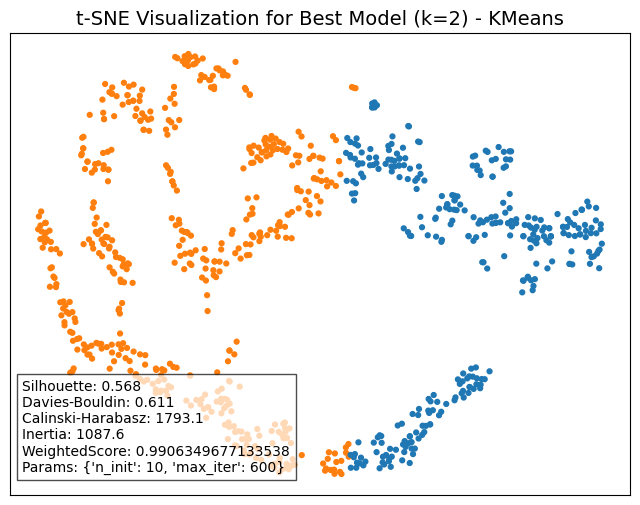

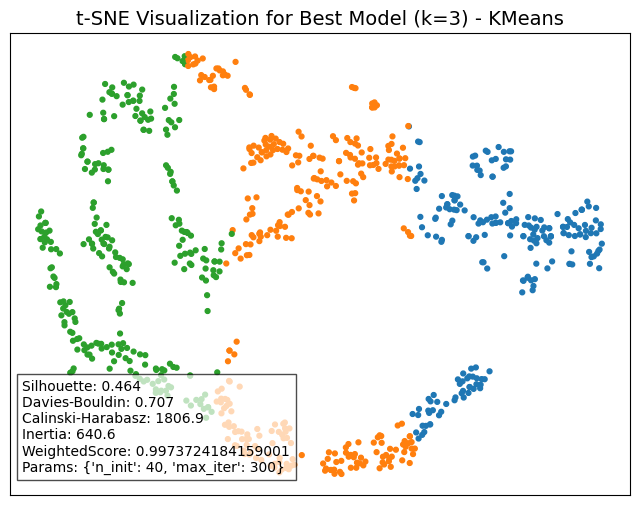

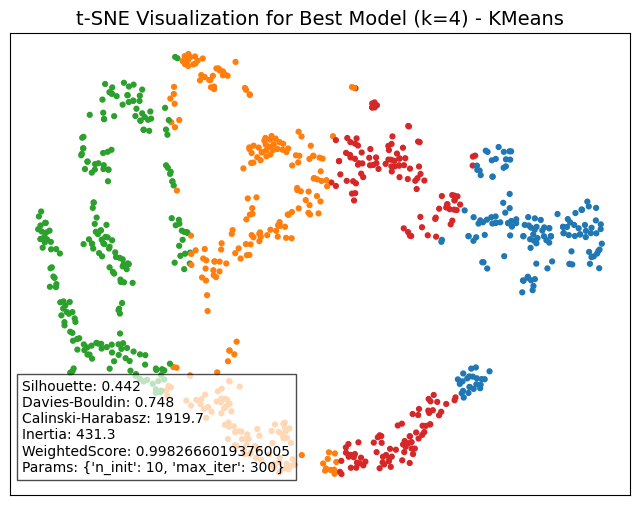

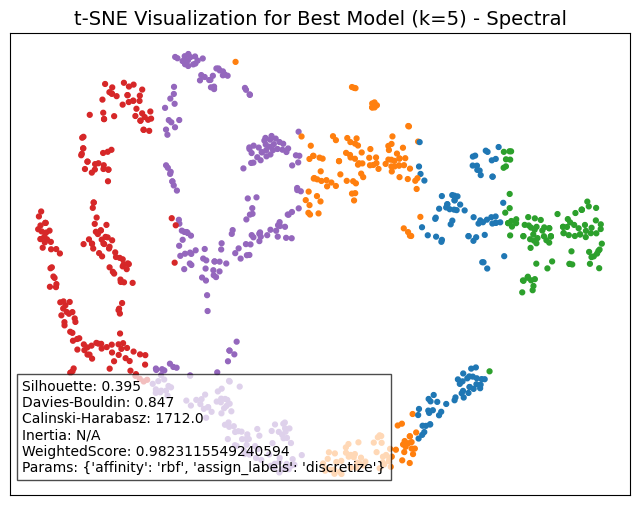

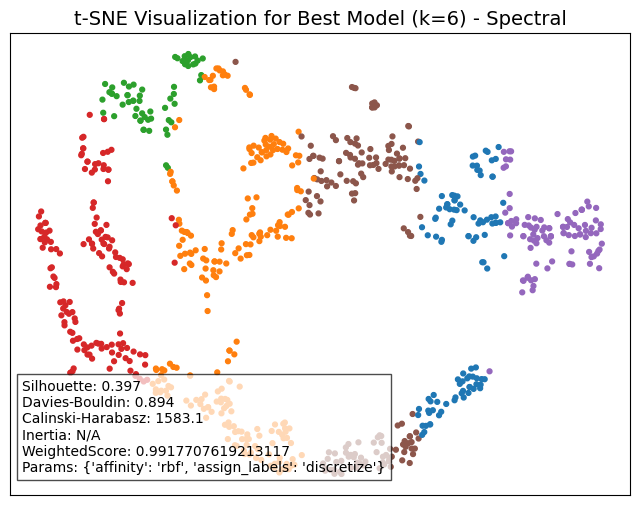

In [194]:
plot_tsne_clusters_df_best(Z,df_best)

In [195]:
def attach_clusters(results_df, model_index, original_df):
    """
    Given a row index in the results_df and the original dataset,
    attach the cluster labels of that model to the original_df.

    Parameters
    ----------
    results_df : pd.DataFrame
        DataFrame containing model results (must have a 'Labels' column)
    model_index : int
        Row index of the chosen model (e.g., 0 for KMeans with 2 clusters)
    original_df : pd.DataFrame
        The original data before clustering (e.g., temp_df)

    Returns
    -------
    pd.DataFrame
        Copy of original_df with a new column 'cluster' containing labels
    """
    # extract the labels from the results table
    labels = results_df.loc[model_index, 'Labels']

    # ensure the length matches
    if len(labels) != len(original_df):
        raise ValueError("Number of labels doesn't match original data length.")

    # make a copy of the original and add the cluster column
    df_with_clusters = original_df.copy()
    df_with_clusters['cluster'] = labels

    return df_with_clusters


In [196]:
df_best=df_best.reset_index().drop('index',axis=1)
df_best

,Model,Clusters,Params,Labels,Inertia,Silhouette,DB,CH,TrainedModel,Silhouette_norm,DB_norm,CH_norm,Inertia_norm,FinalScore
0,KMeans,2,"{'n_init': 10, 'max_iter': 600}","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1087.606689,0.568279,0.610730,1793.113647,"KMeans(max_iter=600, n_clusters=2, n_init=10, ...",1.0,0.953175,1.000000,1.0,0.990635
1,KMeans,3,"{'n_init': 40, 'max_iter': 300}","[2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",640.555359,0.464291,0.707006,1806.914917,"KMeans(n_clusters=3, n_init=40, random_state=42)",1.0,0.986862,1.000000,1.0,0.997372
2,KMeans,4,"{'n_init': 10, 'max_iter': 300}","[2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",431.263184,0.441709,0.747517,1919.677368,"KMeans(n_clusters=4, n_init=10, random_state=42)",1.0,0.992633,1.000000,NaN,0.998267
3,Spectral,5,"{'affinity': 'rbf', 'assign_labels': 'discreti...","[3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",NaN,0.395198,0.847170,1712.040283,"SpectralClustering(assign_labels='discretize',...",1.0,0.936903,0.990337,NaN,0.982312
4,Spectral,6,"{'affinity': 'rbf', 'assign_labels': 'discreti...","[2, 1, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 2, ...",NaN,0.397250,0.894209,1583.101074,"SpectralClustering(assign_labels='discretize',...",1.0,0.984078,0.984758,NaN,0.991771


In [211]:
final_models_info = []

for i in range(df_best.shape[0]):

    model_df = attach_clusters(df_best, i, root_df)
    final_models_info.append(model_df)

    model_name = str(df_best.loc[i, "Model"]).lower()
    k = str(df_best.loc[i, "Clusters"]).lower()

    filename = fr"E:\bridge_cause_analysis\Data\no_supervised_labeling\{model_name}_k{k}.csv"

    model_df.to_csv(filename, index=False)

    print(f"Saved: {filename}")

    


Saved: E:\bridge_cause_analysis\Data\no_supervised_labeling\kmeans_k2.csv
Saved: E:\bridge_cause_analysis\Data\no_supervised_labeling\kmeans_k3.csv
Saved: E:\bridge_cause_analysis\Data\no_supervised_labeling\kmeans_k4.csv
Saved: E:\bridge_cause_analysis\Data\no_supervised_labeling\spectral_k5.csv
Saved: E:\bridge_cause_analysis\Data\no_supervised_labeling\spectral_k6.csv


In [217]:
df_best.to_pickle('df_best.pkl')